[目录](./table_of_contents.ipynb)

# 无迹卡尔曼滤波

In [51]:
%matplotlib inline

In [52]:
#format the book
import book_format
book_format.set_style()

在最后一章，我们讨论了非线性系统所带来的困难。这种非线性可以出现在两个地方。它可以在我们的测量中，比如测量物体的倾斜范围的雷达。倾斜范围要求你取平方根来计算x,y坐标:

$$x=\sqrt{\text{slant}^2 - \text{altitude}^2}$$
 
非线性也可能发生在过程模型中——我们可能跟踪一个在空气中旅行的球，空气阻力的影响导致了非线性行为。对于这类问题，标准卡尔曼滤波器的性能很差，或者根本没有。
 
在上一章，我给你们展示了一个这样的情节。我稍微改变了方程，以强调非线性的影响。

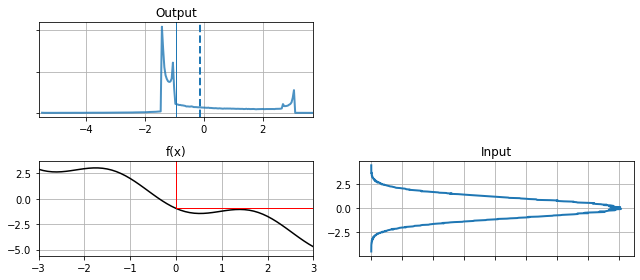

In [53]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np

# create 500,000 samples with mean 0, std 1
gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def f(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

plot_nonlinear_func(data, f)

我从输入中提取50万个样本，通过非线性变换，构建结果的直方图。我们称这些点为点。从输出直方图中，我们可以计算平均值和标准偏差，这将给我们一个更新的，尽管是近似的高斯分布。
 
我给你们看一下数据在通过 `f(x)`之前和之后的散点图。

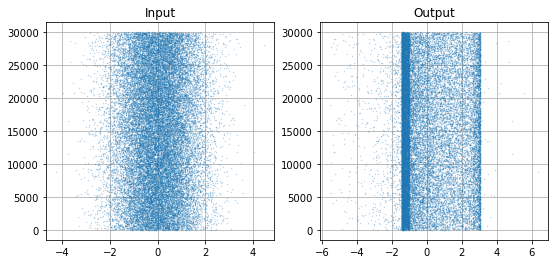

In [54]:
N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(f(data[:N]), range(N), alpha=.2, s=1);

数据本身似乎是高斯分布的，事实也是如此。我的意思是它看起来像白噪声散布在均值0周围。相比之下，`g(data)`有一个已定义的结构。有两个波段，在波段之间有大量的点。在带的外面有分散的点，但在负的一面有更多的点。
 
也许你已经想到这个抽样过程是解决我们问题的一个方法。假设对于每一次更新，我们生成50万个点，将它们传递到函数中，然后计算结果的平均值和方差。这被称为*蒙特卡罗*方法，它被用于一些卡尔曼滤波器的设计，如集合滤波器和粒子滤波器。取样不需要专业知识，也不需要封闭形式的解决方案。无论函数是多么非线性或表现得多么糟糕，只要我们用足够的西格玛点进行抽样，我们就能建立一个准确的输出分布。

“够多的点”是问题所在。上面的图是用50万个sigma点创建的，输出仍然不是平滑的。更糟糕的是，这只适用于一维空间。所需点的数量随维度数的幂次而增加。如果在一维中只需要500个点，那么在二维中需要500的平方，在三维中需要500立方个点，在三维中需要125,000,000个点，以此类推。因此，尽管这种方法有效，但在计算上非常昂贵。集成滤波器和粒子滤波器使用巧妙的技术来显著降低这个维度，但计算负担仍然非常大。无迹卡尔曼滤波器使用sigma点，但通过使用确定性方法来选择这些点，大大减少了计算量。

## Sigma 点-从分布中抽样

让我们从二维协方差椭圆的角度来看这个问题。我选择2D只是因为它很容易绘制;这可以扩展到任何维度。假设某个任意的非线性函数，我们将从第一个协方差椭圆中随机取点，将它们通过非线性函数，并绘制它们的新位置。然后我们可以计算变换点的均值和协方差，并使用它作为均值和概率分布的估计。

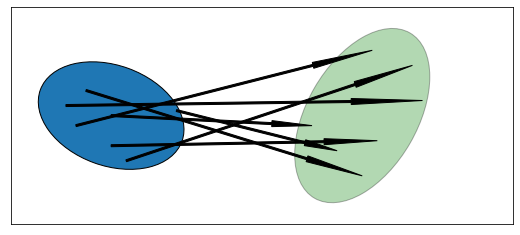

In [55]:
import kf_book.ukf_internal as ukf_internal
ukf_internal.show_2d_transform()

在左边，我们用椭圆表示两个状态变量的$1\sigma$分布。箭头显示了几个随机抽样点如何被一些任意的非线性函数转换成一个新的分布。右边的椭圆是半透明的，表示它是这组点的均值和方差的*估计值。

让我们写一个函数它通过10000个点随机地从高斯函数中抽取

$$\mu = \begin{bmatrix}0\\0\end{bmatrix}, 
\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

通过非线性系统:

$$\begin{cases}\begin{aligned}\bar x&=x+y\\
\bar y&= 0.1x^2 + y^2\end{aligned} \end{cases}$$ 

Difference in mean x=-0.087, y=43.036


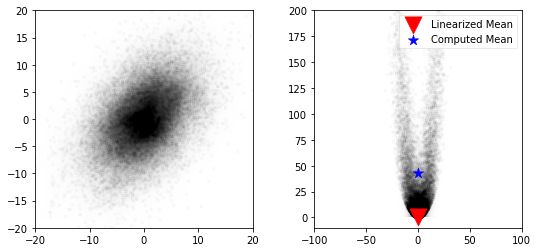

In [56]:
import numpy as np
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

mean = (0., 0.)
p = np.array([[32., 15.], [15., 40.]])
# Compute linearized mean
mean_fx = f_nonlinear_xy(*mean)

#generate random points
xs, ys = multivariate_normal(mean=mean, cov=p, size=10000).T
plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, 'Linearized Mean');

这个图显示了这个函数的强非线性，以及如果我们用扩展卡尔曼滤波器的方式进行线性化会产生的大误差(我们将在下一章学习这个)。

## 一个简单的例子
  
我将很快进入Unscented卡尔曼滤波器(UKF)用于选择sigma点并执行计算的数学。但让我们以一个例子开始，这样你就可以看到目标。

我们将了解到UKF可以使用许多不同的算法来生成sigma点。FilterPy提供了几种算法。这里有一个可能性:

In [57]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

这一点稍后会变得更清楚，但对象将为任何给定的均值和协方差生成加权∑点。让我们来看一个例子，点的大小表示它的权重:

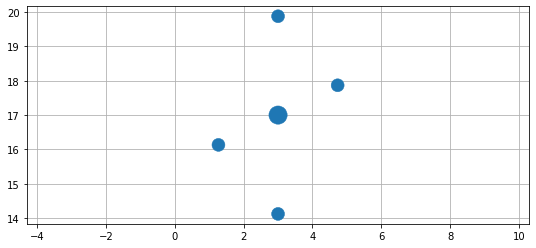

In [58]:
from kf_book.ukf_internal import plot_sigmas
plot_sigmas(sigmas, x=[3, 17], cov=[[1, .5], [.5, 3]])

我们有5个点，以奇数形式围绕平均值(3,17)这可能看起来很荒谬，但它确实能达到或超过50万个随机生成点数!

现在让我们实现过滤器。我们将在1D中实现一个标准线性滤波器;我们还没有准备好处理非线性滤波器。过滤器的设计与我们目前所学的没有太大的不同，只有一点不同。KalmanFilter类使用矩阵$\mathbf F$来计算状态转移函数。矩阵意味着**线性**代数，它适用于线性问题，但不适用于非线性问题。所以，我们提供的不是一个矩阵，而是一个函数，就像我们上面做的那样。KalmanFilter类使用另一个矩阵$\mathbf H$来实现度量函数，它将一个状态转换为等效度量。同样，矩阵意味着线性，所以我们提供一个函数而不是一个矩阵。也许这很清楚为什么$\mathbf H$被称为“测量函数”;对于线性卡尔曼滤波器，它是一个矩阵，但这只是一个快速的方法来计算一个恰好是线性的函数。
 
无需多说，下面是一维跟踪问题的状态转移函数和测量函数，其中状态为$\mathbf x = [x \, \, \dot x]^ \mathsf T$

In [59]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x):
    return x[:1] # return position [x] 

让我们清楚一点，这是一个线性的例子。对于线性问题不需要使用UKF，但我将从最简单的例子开始。但是请注意我是如何写' fx() '来计算$\mathbf{\bar x}$作为一组方程而不是矩阵乘法。这是为了说明我可以在这里实现任意的非线性函数;我们不受线性方程的约束。

其余的设计是一样的。设计$\mathbf P$， $\mathbf R$和$\mathbf Q$。你知道怎么做，所以让我们完成过滤器并运行它。

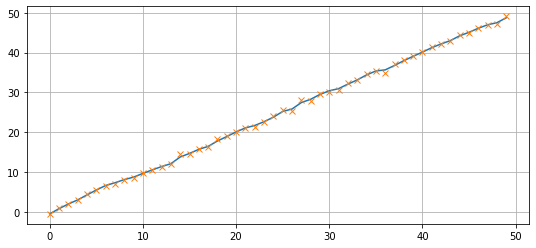

In [60]:
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= .5
ukf.Q = Q_discrete_white_noise(2, dt=1., var=0.03)

zs, xs = [], []
for i in range(50):
    z = i + randn()*.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)
    
plt.plot(xs);
plt.plot(zs, marker='x', ls='');

这里真的没有什么新东西。你必须创建一个对象来为你创建sigma点，并为$\mathbf F$和$\mathbf H$提供函数而不是矩阵，但其余的和之前一样。这应该给你足够的信心，通过一些数学和算法，所以你可以理解UKF正在做什么。

## 选择Sigma点

在本章的开头，我使用了500,000个随机生成的sigma点来计算高斯函数通过非线性函数的概率分布。虽然计算的平均值相当准确，但每次更新计算50万点会导致我们的过滤器非常慢。那么，我们可以使用的采样点的最少数量是多少，这个问题对这些点施加了什么样的约束呢?我们将假设我们没有关于非线性函数的特殊知识，因为我们想要找到一个适用于任何函数的广义算法。

Let's consider the simplest possible case and see if it offers any insight. The simplest possible system is the **identity function**: $f(x) = x$. If our algorithm does not work for the identity function then the filter cannot converge. In other words, if the input is  1 (for a one dimensional system), the output must also be 1. If the output was different, such as 1.1, then when we fed 1.1 into the transform at the next time step, we'd get out yet another number, maybe 1.23. This filter diverges. 
>让我们考虑最简单的可能情况，看看它是否提供了任何见解。最简单的系统是**恒等函数**:$f(x) = x$。如果我们的算法对恒等函数不起作用，那么滤波器就不能收敛。换句话说，如果输入是1(对于一维系统)，输出也必须是1。如果输出是不同的，比如1.1，那么当我们在下一个时间步骤将1.1输入转换时，我们会得到另一个数字，可能是1.23。这个过滤器是发散的。

The fewest number of points that we can use is one per dimension. This is the number that the linear Kalman filter uses. The input to a Kalman filter for the distribution $\mathcal{N}(\mu,\sigma^2)$ is $\mu$ itself. So while this works for the linear case, it is not a good answer for the nonlinear case.
>我们可以使用的点的最少数量是每个维度一个。这是线性卡尔曼滤波器使用的数字。分布$\mathcal{N}(\mu，\sigma^2)$的卡尔曼滤波器输入是$\mu$本身。虽然这对线性情况有效，但对非线性情况却不是一个好的答案。

Perhaps we can use one point per dimension, but altered somehow. However, if we were to pass some value $\mu+\Delta$ into the identity function $f(x)=x$ it would not converge, so this will not work. If we didn't alter $\mu$ then this would be the standard Kalman filter. We must conclude that one sample will not work.
>也许我们可以在每个维度上使用一个点，但要有所改变。然而，如果我们传递一个值$ mu+ $到恒等函数$f(x)=x$它就不会收敛，所以这行不通。如果我们不改变$\mu$那么这就是标准卡尔曼滤波器。我们必须得出这样的结论:一个样品是行不通的。

What is the next lowest number we can choose? Two. Consider the fact that Gaussians are symmetric, and that we probably want to always have one of our sample points be the mean of the input for the identity function to work. Two points would require us to select the mean, and then one other point. That one other point would introduce an asymmetry in our input that we probably don't want. It would be very difficult to make this work for the identity function $f(x)=x$.
>下一个最小的数是多少?两个。考虑到高斯函数是对称的，我们可能希望总有一个样本点是恒等函数输入的均值。两个点需要选择均值，然后是另一个点。另一个点会在我们的输入中引入一个我们可能不想要的不对称。对于恒等函数$f(x)=x$来说，这是很难做到的。

The next lowest number is 3 points. 3 points allows us to select the mean, and then one point on each side of the mean, as depicted on the chart below.
>下一个最低的数字是3分。3个点可以让我们选择均值，然后在均值的两边各选一个点，如下图所示。

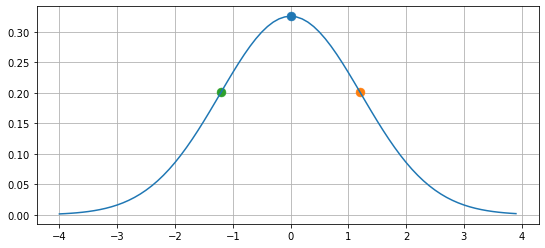

In [61]:
ukf_internal.show_3_sigma_points()

We can pass these points through a nonlinear function f(x) and compute the resulting mean and variance. The mean can be computed as the average of the 3 points, but that is not very general. For example, for a very nonlinear problem we might want to weight the center point much higher than the outside points, or we might want to weight the outside points higher. 
>我们可以通过非线性函数f(x)来传递这些点，并计算得到的平均值和方差。平均值可以计算为3个点的平均值，但这不是很普遍。例如，对于一个非常非线性的问题我们可能希望中心点的权重比外围点高很多，或者我们可能希望外围点的权重更高。

A more general approach is to compute the weighted mean $\mu = \sum_i w_i\, f(\mathcal{X}_i)$, where the calligraphic $\mathcal{X}$ are the sigma points.  We need the sums of the weights to equal one. Given that requirement, our task is to select $\mathcal{X}$ and their corresponding weights so that they compute to the mean and variance of the transformed sigma points. 
>更一般的方法是计算加权平均$\mu = \sum_i w_i\， f(\mathcal{X}_i)$，其中$\mathcal{X}$是sigma点。我们需要权重之和等于1。给定该需求，我们的任务是选择$\mathcal{X}$及其相应的权重，以便计算转换后的∑点的均值和方差。

If we weight the means it also makes sense to weight the covariances. It is possible to use different weights for the mean ($w^m$) and for the covariance ($w^c$). I use superscripts to allow space for indexes in the following equations. We can write
>如果我们对均值进行加权，那么对协方差进行加权也有意义。可以对平均值($w^m$)和协方差($w^c$)使用不同的权重。我使用上标来为下列方程中的索引留出空间。我们可以写

$$\begin{aligned}
\mathbf{Constraints:}\\
1 &= \sum_i{w_i^m} \\
1 &= \sum_i{w_i^c} \\
\mu &= \sum_i w_i^mf(\mathcal{X}_i) \\
\Sigma &= \sum_i w_i^c{(f(\mathcal{X})_i-\mu)(f(\mathcal{X})_i-\mu)^\mathsf{T}}
\end{aligned}
$$

The first two equations are the constraint that the weights must sum to one. The third equation is how you compute a weight mean. The forth equation may be less familiar, but recall that the equation for the covariance of two random variables is:
>前两个方程是权值必须和为1的约束条件。第三个方程是如何计算权重均值。第四个方程可能不太熟悉，但请记住，两个随机变量的协方差方程为:

$$COV(x,y) = \frac{\sum(x-\bar x)(y-\bar{y})}{n}$$

These constraints do not form a unique solution. For example, if you make $w^m_0$ smaller you can compensate by making $w^m_1$ and $w^m_2$ larger. You can use different weights for the mean and covariances, or the same weights. Indeed, these equations do not require that any of the points be the mean of the input at all, though it seems 'nice' to do so, so to speak.
>这些约束条件并不是唯一解。例如，如果你使$w^m_0$变小，你可以通过使$w^m_1$和$w^m_2$变大来进行补偿。均值和协方差可以用不同的权重，也可以用相同的权重。事实上，这些方程并不要求任何点都是输入的均值，尽管这么做似乎很“好”。

We want an algorithm that satisfies the constraints, preferably with only 3 points per dimension. Before we go on I want to make sure the idea is clear. Below are three different examples for the same covariance ellipse with different sigma points. The size of the sigma points is proportional to the weight given to each.
>我们想要一个满足约束条件的算法，最好每个维度只有3个点。在我们继续之前，我想确认一下这个想法是否清晰。下面是三个不同的例子，相同的协方差椭圆有不同的西格玛点。点的大小与每个点的权重成正比。

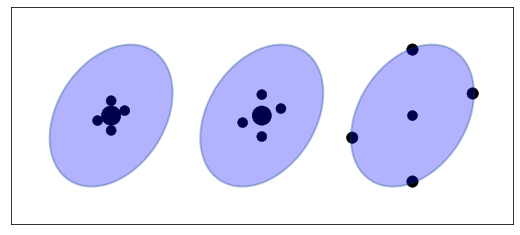

In [62]:
ukf_internal.show_sigma_selections()

The points do not lie along the major and minor axis of the ellipse; nothing in the constraints require me to do that. I show the points evenly spaced, but the constraints do not require that. 
>这些点不沿着椭圆的长轴和短轴;没有约束条件要求我这么做。我展示了均匀间隔的点，但约束条件不要求这样。

The arrangement and weighting of the sigma points affect how we sample the distribution. Points that are close together will sample local effects, and thus probably work better for very nonlinear problems. Points that are far apart, or far off the axis of the ellipse will sample non-local effects and non Gaussian behavior. However, by varying the weights used for each point we can mitigate this. If the points are far from the mean but weighted very slightly we will incorporate some of the knowledge about the distribution without allowing the nonlinearity of the problem to create a bad estimate. 
>点的排列和权重影响我们如何抽样分布。靠得近的点会取样局部效应，因此可能对非常非线性的问题更有效。距离较远的点，或离椭圆轴较远的点将采样非局部效应和非高斯行为。然而，通过改变每个点的权重，我们可以减轻这个问题。如果这些点离平均值很远，但权重很小，我们就会吸收一些关于分布的知识，而不会让问题的非线性产生一个糟糕的估计。

Please understand there are infinite ways to select sigma points. The constraints I choose are just one way to do it. For example, not all algorithms for creating the sigma points require the weights to sum to one. In fact, the algorithm I favor in this book does not have that property.
>请理解选择西格玛点的方法有很多。我选择的约束条件只是一种方法。例如，不是所有创建sigma点的算法都要求权重之和为1。事实上，我在这本书中喜欢的算法没有这个特性。

## 无迹变换

For the moment, assume an algorithm for selecting the sigma points and weights exists. How are the sigma points used to implement a filter?
>目前，假设存在选择sigma点和权重的算法。如何使用西格玛点来实现过滤器?

The *unscented transform* is the core of the algorithm yet it is remarkably simple. It passes the sigma points $\boldsymbol{\chi}$ through a nonlinear function yielding a transformed set of points. 
>“无迹变换”是算法的核心，但它非常简单。它将σ点$\boldsymbol{\chi}$通过一个非线性函数，得到一组经过变换的点。

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

It then computes the mean and covariance of the transformed points. That mean and covariance becomes the new estimate. The figure below depicts the operation of the unscented transform. The green ellipse on the right represents the computed mean and covariance to the transformed sigma points. 
>然后计算变换后点的均值和协方差。均值和协方差变成了新的估计。下图描述了unscented变换的操作。右边的绿色椭圆表示变换后的点的计算平均值和协方差。

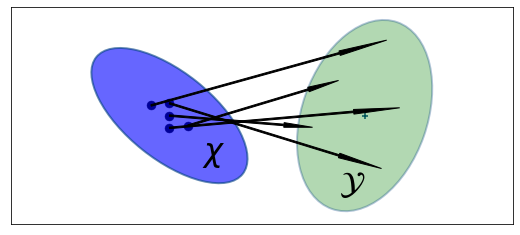

In [63]:
ukf_internal.show_sigma_transform(with_text=True)

The mean and covariance of the sigma points are computed as:
>sigma点的均值和协方差计算如下:

$$\begin{aligned}
\mu &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal{Y}}_i \\
\Sigma &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal{Y}}_i-\mu)(\boldsymbol{\mathcal{Y}}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

These equations should be familiar - they are the constraint equations we developed above. 
>这些方程应该很熟悉——它们是我们在上面推导的约束方程。

In short, the unscented transform takes points sampled from some arbitary probability distribution, passes them through an arbitrary, nonlinear function and produces a Gaussian for each transformed points. I hope you can envision how we can use this to implement a nonlinear Kalman filter. Once we have Gaussians all of the mathematical apparatus we have already developed comes into play!
>简而言之，无迹变换从一些随机概率分布中取点，将它们通过一个任意的非线性函数，并为每个变换点生成一个高斯函数。我希望你们能想象我们如何用它来实现非线性卡尔曼滤波器。一旦我们有了高斯函数，我们已经开发的所有数学仪器就开始发挥作用了!

The name "unscented" might be confusing. It doesn't really mean much. It was a joke fostered by the inventor that his algorithm didn't "stink", and soon the name stuck. There is no mathematical meaning to the term.
>“无味”这个名字可能会让人困惑。这并不意味着什么。这是发明者编造的一个笑话，说他的算法并不“糟糕”，很快这个名字就流传下来了。这个术语没有数学上的意义。

### Unscented变换的准确性

Earlier we wrote a function that found the mean of a distribution by passing 50,000 points through a nonlinear function. Let's now pass 5 sigma points through the same function, and compute their mean with the unscented transform. We will use the FilterPy function *MerweScaledSigmaPoints()* to create the sigma points and `unscented_transform` to perform the transform; we will learn about these functions later. In the first example in this chapter I used `JulierSigmaPoints`; they both choose sigma points, but in different ways which I will explain later.
>早些时候，我们写了一个函数，通过一个非线性函数通过50000个点来求分布的均值。现在让5个点通过同一个函数，然后用单调变换计算它们的均值。我们将使用FilterPy函数* merwescaledsigmpoints()*来创建sigma点，并使用' unscented_transform '来执行转换;稍后我们将学习这些函数。在本章的第一个例子中，我使用了' juliersigmappoints ';它们都选择了点，但方式不同，我稍后会解释。

Difference in mean x=-0.097, y=0.549


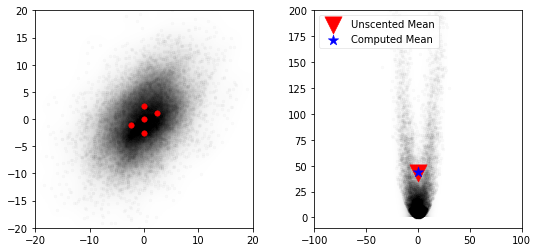

In [64]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
import scipy.stats as stats


#initial mean and covariance
mean = (0., 0.)
p = np.array([[32., 15], [15., 40.]])

# create sigma points and weights
points = MerweScaledSigmaPoints(n=2, alpha=.3, beta=2., kappa=.1)
sigmas = points.sigma_points(mean, p)

### pass through nonlinear function
sigmas_f = np.empty((5, 2))
for i in range(5):
    sigmas_f[i] = f_nonlinear_xy(sigmas[i, 0], sigmas[i ,1])

### use unscented transform to get new mean and covariance
ukf_mean, ukf_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)

#generate random points
np.random.seed(100)
xs, ys = multivariate_normal(mean=mean, cov=p, size=5000).T

plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, ukf_mean, 'Unscented Mean')
ax = plt.gcf().axes[0]
ax.scatter(sigmas[:,0], sigmas[:,1], c='r', s=30);

I find this result remarkable. Using only 5 points we were able to compute the mean with amazing accuracy. The error in x is only -0.097, and the error in y is 0.549. In contrast, a linearized approach (used by the EKF, which we will learn in the next chapter) gave an error of over 43 in y. If you look at the code that generates the sigma points you'll see that it has no knowledge of the nonlinear function, only of the mean and covariance of our initial distribution. The same 5 sigma points would be generated if we had a completely different nonlinear function. 
>我觉得这个结果很了不起。只用5个点，我们就能以惊人的准确性计算出平均值。x的误差仅为-0.097,y的误差为0.549。相比之下,线性化方法(使用的卡尔曼滤波器,在下一章我们将学习)在43 y的给了一个错误。如果你看看生成的代码σ点你会发现它没有非线性函数的知识,只有我们最初的均值和协方差的分布。同样的5个点如果我们有一个完全不同的非线性函数。

I will admit to choosing a nonlinear function that makes the performance of the unscented tranform striking compared to the EKF. But the physical world is filled with very nonlinear behavior, and the UKF takes it in stride. I did not 'work' to find a function where the unscented transform happened to work well. You will see in the next chapter how more traditional techniques struggle with strong nonlinearities. This graph is the foundation of why I advise you to use the UKF or similar modern technique whenever possible.
>我承认选择了一个非线性函数，使无气味变换的性能与EKF相比引人注目。但物理世界充满了非常非线性的行为，UKF从容应对。我没有“工作”去寻找一个函数，在那里无味的变换碰巧工作得很好。在下一章中，您将看到更传统的技术如何与强非线性作斗争。这张图是我建议您尽可能使用UKF或类似现代技术的基础。

## 无味卡尔曼滤波

现在我们可以展示UKF算法。

### 预测步骤

The UKF's predict step computes the prior using the process model $f()$. $f()$ is assumed to be nonlinear, so we generate sigma points $\mathcal{X}$ and their corresponding weights $W^m, W^c$
according to some function:
>UKF的预测步骤使用流程模型$f()$计算前面的步骤。假设$f()$是非线性的，则根据某个函数生成sigma点$\mathcal{X}$及其相应的权值$W^m, W^c$:

$$\begin{aligned}
\boldsymbol\chi &= \text{sigma-function}(\mathbf x, \mathbf P) \\
W^m, W^c &= \text{weight-function}(\mathtt{n, parameters})\end{aligned}$$

We pass each sigma point through $f(\mathbf x, \Delta t)$. This projects the sigma points forward in time according to the process model, forming the new prior, which is a set of sigma points we name $\boldsymbol{\mathcal Y}$:
>我们通过$f(\mathbf x， \ t)$传递每个sigma点。这将根据过程模型及时向前投射sigma点，形成新的先验，这是一组sigma点，我们将其命名为$\boldsymbol{\mathcal Y}$:

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi}, \Delta t)$$

We compute the mean and covariance of the prior using the *unscented transform* on the transformed sigma points.  
>我们计算平均值和协方差的先验使用*无气味变换*对转换的sigma点。

$$\mathbf{\bar x}, \mathbf{\bar P} = 
UT(\mathcal{Y}, w_m, w_c, \mathbf Q)$$

These are the equations for the unscented transform:
>这些是无味变换的方程:

$$\begin{aligned}
\mathbf{\bar x} &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Y}_i \\
\mathbf{\bar P} &= \sum_{i=0}^{2n} w^c_i({\boldsymbol{\mathcal Y}_i - \mathbf{\bar x})(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})^\mathsf{T}} + \mathbf Q
\end{aligned}
$$

This table compares the linear Kalman filter with the Unscented Kalman Filter equations. I've dropped the subscript $i$ for readability.
>这个表格比较了线性卡尔曼滤波器和无迹卡尔曼滤波器方程。为了便于阅读，我去掉了下标 $i$ 。

$$\begin{array}{l|l}
\text{Kalman} & \text{Unscented} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T + \mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q
\end{array}$$

### 更新步骤

Kalman filters perform the update in measurement space. Thus we must convert the sigma points of the prior into measurements using a measurement function $h(x)$ that you define.
>卡尔曼滤波器在测量空间中执行更新。因此，我们必须使用您定义的测量函数$h(x)$将先验的西格玛点转换为测量值。

$$\boldsymbol{\mathcal{Z}} = h(\boldsymbol{\mathcal{Y}})$$

We compute the mean and covariance of these points using the unscented transform. The $z$ subscript denotes that these are the mean and covariance of the measurement sigma points.
>我们使用无味变换计算这些点的均值和协方差。$z$下标表示这些是测量sigma点的平均值和协方差。

$$\begin{aligned}
\boldsymbol\mu_z, \mathbf P_z &= 
UT(\boldsymbol{\mathcal Z}, w_m, w_c, \mathbf R) \\
\boldsymbol\mu_z &= \sum_{i=0}^{2n} w^m_i\boldsymbol{\mathcal Z}_i \\
\mathbf P_z &= \sum_{i=0}^{2n} w^c_i{(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)(\boldsymbol{\mathcal Z}_i-\boldsymbol{\mu}_z)^\mathsf T} + \mathbf R
\end{aligned}
$$

Next we compute the residual and Kalman gain. The residual of the measurement $\mathbf z$ is trivial to compute:
>然后计算残差和卡尔曼增益。测量的剩余$\mathbf z$是很容易计算的:

$$\mathbf y = \mathbf z - \boldsymbol\mu_z$$

To compute the Kalman gain we first compute the [cross covariance](https://en.wikipedia.org/wiki/Cross-covariance) of the state and the measurements, which is defined as: 
>为了计算卡尔曼增益，我们首先计算状态和测量值的[交叉协方差](https://en.wikipedia.org/wiki/Cross-covariance)，定义为:

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$

And then the Kalman gain is defined as
>然后定义卡尔曼增益为

$$\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}$$

If you think of the inverse as a *kind of* matrix reciprocal, you can see that the Kalman gain is a simple ratio which computes:
>如果你把逆看作是一种*矩阵的倒数，你可以看到卡尔曼增益是一个简单的比率，它计算:

$$\mathbf{K} \approx \frac{\mathbf P_{xz}}{\mathbf P_z} 
\approx \frac{\text{belief in state}}{\text{belief in measurement}}$$

Finally, we compute the new state estimate using the residual and Kalman gain:
>最后，利用残差和卡尔曼增益计算新的状态估计:

$$\mathbf x = \bar{\mathbf x} + \mathbf{Ky}$$

and the new covariance is computed as:
>新的协方差计算为:

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}$$

This step contains a few equations you have to take on faith, but you should be able to see how they relate to the linear Kalman filter equations. The linear algebra is slightly different from the linear Kalman filter, but the algorithm is the same Bayesian algorithm we have been implementing throughout the book. 
>这一步包含一些你必须相信的方程，但是你应该能够看到它们是如何与线性卡尔曼滤波方程相关联的。线性代数与线性卡尔曼滤波略有不同，但算法与我们在书中一直使用的贝叶斯算法相同。

This table compares the equations of the linear KF and UKF equations.
>该表比较了线性KF方程和线性UKF方程。

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$

## 范德默维缩放西格玛点算法

There are many algorithms for selecting sigma points.  Since 2005 or so research and industry have mostly settled on the version published by Rudolph Van der Merwe in his 2004 PhD dissertation [1]. It performs well with a variety of problems and it has a good tradeoff between performance and accuracy. It is a slight reformulation of the *Scaled Unscented Transform* published by Simon J. Julier [2].
>有很多选择点的算法。大约从2005年开始，研究和工业大多采用Rudolph Van der Merwe在他2004年的博士论文[1]中发表的版本。它在处理各种问题时表现良好，并且在性能和精度之间有很好的权衡。这是对Simon J. Julier[2]发表的*Scaled Unscented Transform*的一个轻微的重新设计。

This formulation uses 3 parameters to control how the sigma points are distributed and weighted: $\alpha$, $\beta$, and $\kappa$. Before we work through the equations, let's look at an example. I will plot the sigma points on top of a covariance ellipse showing the first and second standard deviations, and scale the points based on  the mean weights.
>这个公式使用3个参数来控制点数的分布和加权:$\alpha$， $\beta$和$\kappa$。在我们研究这些方程之前，让我们看一个例子。我将在一个显示第一和第二个标准差的协方差椭圆上绘制sigma点，并根据平均权重对这些点进行缩放。

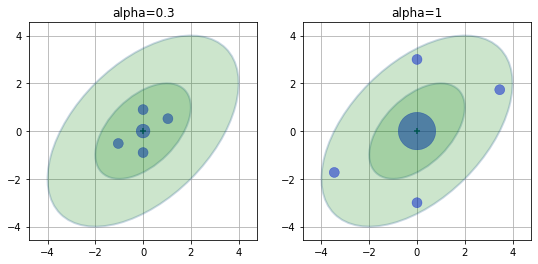

In [65]:
ukf_internal.plot_sigma_points()

We can see that the sigma points lie between the first and second standard deviation, and that the larger $\alpha$ spreads the points out. Furthermore, the larger $\alpha$ weights the mean (center point) higher than the smaller $\alpha$, and weights the rest less. This should fit our intuition - the further a point is from the mean the less we should weight it. We don't know how these weights and sigma points are selected yet, but the choices look reasonable.
>我们可以看到σ点位于第一个和第二个标准差之间，并且较大的$\alpha$将这些点分开。而且，较大的$\alpha$的权重比较小的$\alpha$的平均值(中心点)高，其余的权重更低。这应该符合我们的直觉-点离均值越远，我们就越不应该加权它。我们还不知道这些权重和点是如何选择的，但选择看起来是合理的。

### Sigma 点计算

The first sigma point is the mean of the input. This is the sigma point displayed in the center of the ellipses in the diagram above. We will call this $\boldsymbol{\chi}_0$.
>第一个点是输入的均值。这是在上图中椭圆中心显示的sigma点。我们将其命名为$\boldsymbol{\chi}_0$。

$$ \mathcal{X}_0 = \mu$$

For notational convenience we define $\lambda = \alpha^2(n+\kappa)-n$, where $n$ is the dimension of $\mathbf x$. The remaining sigma points are computed as
>为了便于记法，我们定义$\lambda = \alpha²(n+\kappa)-n$，其中$n$是$\mathbf x$的维数。其余的点计算为

$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(n+\lambda)\Sigma}\right ]_{i}& \text{for i=1 .. n} \\
\mu - \left[ \sqrt{(n+\lambda)\Sigma}\right]_{i-n} &\text{for i=(n+1) .. 2n}\end{cases}
$$
The $i$ subscript chooses the i$^{th}$ roth vector of the matrix.
>$i$下标选择矩阵的i$^{th}$ roth向量。

In other words, we scale the covariance matrix by a constant, take the square root of it, and ensure symmetry by both adding and subtracting it from the mean. We will discuss how you take the square root of a matrix later.
>换句话说，我们用一个常数缩放协方差矩阵，取它的平方根，通过在均值上加或减它来确保对称性。我们稍后将讨论如何求矩阵的平方根。

### 权重计算

This formulation uses one set of weights for the means, and another set for the covariance. The weights for the mean of $\mathcal{X}_0$ is computed as
>这个公式用一组权重表示均值，用另一组权重表示协方差。$\mathcal{X}_0$的均值的权重计算为

$$W^m_0 = \frac{\lambda}{n+\lambda}$$

The weight for the covariance of $\mathcal{X}_0$ is
>$\mathcal{X}_0$协方差的权重为

$$W^c_0 = \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta$$

The weights for the rest of the sigma points $\boldsymbol{\chi}_1 ... \boldsymbol{\chi}_{2n}$ are the same for the mean and covariance. They are
>其余的权重值$\boldsymbol{\chi}_1…黑体符号{\chi}_{2n}$对于均值和协方差是相同的。他们是

$$W^m_i = W^c_i = \frac{1}{2(n+\lambda)}\;\;\;i=1..2n$$

It may not be obvious why this is 'correct', and indeed, it cannot be proven that this is ideal for all nonlinear problems. But you can see that we are choosing the sigma points proportional to the square root of the covariance matrix, and the square root of variance is standard deviation. So, the sigma points are spread roughly according to $\pm 1\sigma$ times some scaling factor. There is an $n$ term in the denominator, so with more dimensions the points will be spread out and weighed less.
>为什么这是“正确的”可能不是很明显，事实上，它不能证明这是理想的所有非线性问题。大家可以看到我们选择的点与协方差矩阵的平方根成正比，方差的平方根是标准差。所以，点的分布大致是根据$ pm 1∑$乘以某个比例因子。分母中有$n$项，所以维度越多，点就越分散，权重也就越小。

**Important note:** Ordinarily these weights do not sum to one. I get many questions about this. Getting weights that sum to greater than one, or even negative values is expected. I cover this in more detail below.
>**重要提示:**通常这些权重总和不是1。我对此有很多疑问。期望得到大于1甚至负值的权值。我将在下面详细介绍这一点。

### 参数的合理选择

$\beta=2$ is a good choice for Gaussian problems, $\kappa=3-n$ where $n$ is the dimension of $\mathbf x$ is a good choice for $\kappa$, and $0 \le \alpha \le 1$ is an appropriate choice for $\alpha$, where a larger value for $\alpha$ spreads the sigma points further from the mean.
>$\beta=2$是高斯问题的好选择，$\kappa=3-n$，其中$n$是$\mathbf x的维数$是$\kappa$的好选择，$0 \le \alpha \le 1$是$\alpha$的合适选择，其中$\alpha$的较大值使σ点离平均值更远。

## 使用UKF

Let's solve some problems so you can gain confidence in how easy the UKF is to use. We will start with a linear problem you already know how to solve with the linear Kalman filter. Although the UKF was designed for nonlinear problems, it finds the same optimal result as the linear Kalman filter for linear problems. We will write a filter to track an object in 2D using a constant velocity model. This will allow us to focus on what is the same (and most is the same!) and what is different with the UKF. 
>让我们来解决一些问题，这样您就可以对UKF的使用有多容易有信心了。我们将从一个你们已经知道如何用线性卡尔曼滤波器解决的线性问题开始。尽管UKF是为非线性问题设计的，但它与线性卡尔曼滤波器对线性问题的最优结果相同。我们将编写一个过滤器来跟踪二维物体使用一个恒定速度模型。这将允许我们专注于什么是相同的(和大多数是相同的!)和什么是不同的UKF。

Designing a Kalman filter requires you to specify the $\bf{x}$, $\bf{F}$, $\bf{H}$, $\bf{R}$, and $\bf{Q}$ matrices. We have done this many times so I will give you the matrices without a lot of discussion. We want a constant velocity model, so we define $\bf{x}$ to be
>设计卡尔曼滤波器需要指定$\bf{x}$、$\bf{F}$、$\bf{H}$、$\bf{R}$和$\bf{Q}$矩阵。我们已经做过很多次了所以我不需要太多的讨论就给你们这些矩阵。我们想要一个匀速模型，所以我们定义$\bf{x}$为

$$ \mathbf x = \begin{bmatrix}x &  \dot x & y & \dot y \end{bmatrix}^\mathsf{T}$$

With this ordering of state variables the state transition matrix is
>根据状态变量的顺序，状态转移矩阵是

$$\mathbf F = \begin{bmatrix}1 & \Delta t & 0 & 0 \\
0&1&0&0 \\
0&0&1&\Delta t\\
0&0&0&1
\end{bmatrix}$$

which implement the Newtonian equations
>实现了牛顿方程

$$\begin{aligned}
x_k &= x_{k-1} + \dot x_{k-1}\Delta t \\
y_k &= y_{k-1} + \dot y_{k-1}\Delta t
\end{aligned}$$

Our sensors provide position but not velocity, so the measurement function is
>我们的传感器提供位置，但不提供速度，所以测量功能是

$$\mathbf H = \begin{bmatrix}1&0&0&0 \\ 0&0&1&0
\end{bmatrix}$$

The sensor readings are in meters with an error of $\sigma=0.3$ meters in both *x* and *y*. This gives us a measurement noise matrix of 
>传感器读数以米为单位，在*x*和*y*的误差均为$\sigma=0.3$米。这给了我们一个测量噪声矩阵

$$\mathbf R = \begin{bmatrix}0.3^2 &0\\0 & 0.3^2\end{bmatrix}$$

Finally, let's assume that the process noise can be represented by the discrete white noise model - that is, that over each time period the acceleration is constant. We can use `FilterPy`'s `Q_discrete_white_noise()` to create this matrix for us, but for review the matrix is
>最后，让我们假设过程噪声可以用离散白噪声模型表示——也就是说，在每个时间段内，加速度是恒定的。我们可以使用FilterPy 's ' Q_discrete_white_noise() '来为我们创建这个矩阵，但是为了查看矩阵是

$$\mathbf Q = \begin{bmatrix}
\frac{1}{4}\Delta t^4 & \frac{1}{2}\Delta t^3 \\
\frac{1}{2}\Delta t^3 & \Delta t^2\end{bmatrix} \sigma^2$$

My implementation of this filter is:
>这个过滤器的实现是:

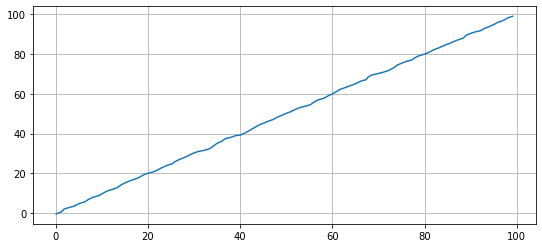

In [66]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy.random import randn

std_x, std_y = .3, .3
dt = 1.0

np.random.seed(1234)
kf = KalmanFilter(4, 2)
kf.x = np.array([0., 0., 0., 0.])
kf.R = np.diag([std_x**2, std_y**2])
kf.F = np.array([[1, dt, 0, 0], 
                 [0, 1, 0, 0],
                 [0, 0, 1, dt],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 0, 1, 0]])
 
kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

zs = [np.array([i + randn()*std_x, 
                i + randn()*std_y]) for i in range(100)]               
xs, _, _, _ = kf.batch_filter(zs)
plt.plot(xs[:, 0], xs[:, 2]);

This should hold no surprises for you. Now let's implement a UKF. Again, this is purely for educational purposes; using a UKF for a linear problem confers no benefit. `FilterPy` implements the UKF with the class `UnscentedKalmanFilter`. 
>这应该不会让你感到惊讶。现在让我们实现一个UKF。再说一次，这纯粹是为了教育目的;对线性问题使用UKF没有任何好处。' FilterPy '通过类' UnscentedKalmanFilter '实现UKF。

The first thing to do is implement the functions `f(x, dt)` and `h(x)`. `f(x, dt)` implements the state transition function, and `h(x)` implements the measurement function. These correspond to the matrices $\mathbf F$ and $\mathbf H$ in the linear filter.
>首先要做的是实现函数f(x, dt)和h(x)f(x, dt)实现了状态转移函数，而h(x)实现了测量函数。这些对应于线性滤波器中的矩阵$\mathbf F$和$\mathbf H$。

Below is a reasonable implementation of these two functions. Each is expected to return a 1D NumPy array or list containing the result. You may give them more readable names than `f` and `h`.
>下面是这两个函数的合理实现。每个都将返回一个包含结果的1D NumPy数组或列表。你可以给它们起一个比' f '和' h '更有可读性的名字。

In [67]:
def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]])
    return F @ x

def h_cv(x):
    return x[[0, 2]]

Next you specify how to compute the sigma points and weights. We gave Van der Merwe's  version above, but there are many different choices. FilterPy uses a class named `SigmaPoints` which must implement a method:
>接下来指定如何计算点和权重。上面我们给出了Van der Merwe的版本，但是有许多不同的选择。FilterPy使用一个名为' sigmappoints '的类，该类必须实现一个方法:

```python
def sigma_points(self, x, P)
```

and contain attributes `Wm` and `Wc`, which hold the weights for computing the mean and covariance, respectively.

FilterPy derives the class `MerweScaledSigmaPoints` from `SigmaPoints` and implements the aforementioned methods.

When you create the UKF you will pass in the $f()$ and $h()$ functions and the sigma point  object, as in this example:
>并包含属性‘Wm’和‘Wc’，它们分别持有计算平均值和协方差的权重。
FilterPy从' sigmappoints '派生类' merwescaledsigmappoints '，并实现上述方法。
当你创建UKF时，你会传入$f()$和$h()$函数和sigma点对象，就像下面这个例子:

```python
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv, hx=h_cv, dt=dt, points=points)
```

The rest of the code is the same as for the linear kalman filter. I'll use the same measurements and compute the standard deviation of the difference between the two solutions.
>代码的其余部分与线性卡尔曼滤波器相同。我将使用相同的测量方法计算两个解之间差的标准差。

UKF standard deviation 0.013 meters


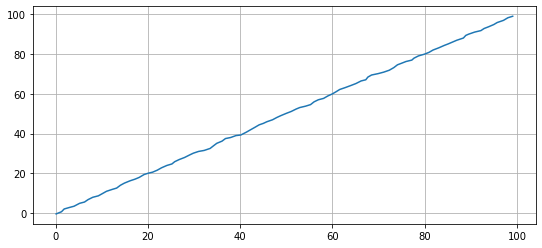

In [68]:
from filterpy.kalman import UnscentedKalmanFilter as UKF

import numpy as np

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=1.)
ukf = UKF(dim_x=4, dim_z=2, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([0.09, 0.09]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=1, var=0.02)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=1, var=0.02)

uxs = []
for z in zs:
    ukf.predict()
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)

plt.plot(uxs[:, 0], uxs[:, 2])
print(f'UKF standard deviation {np.std(uxs - xs):.3f} meters')

This gave me a standard deviation of 0.013 meters, which is quite small. 
>这给了我0.013米的标准偏差，这是相当小的。

The implementation of the UKF is not that different from the linear Kalman filter. Instead of implementing the state transition and measurement functions as the matrices $\mathbf F$ and $\mathbf H$ you supply nonlinear functions `f()` and `h()`. The rest of the theory and implementation remains the same. The code implementing `predict()` and `update()` differs, but from a designer's point of view the problem formulation and filter design is very similar.
>UKF的实现与线性卡尔曼滤波器没有太大的不同。不是将状态转换和度量函数实现为矩阵$\mathbf F$和$\mathbf H$，而是提供非线性函数' F() '和' H() '。其余的理论和实施保持不变。实现‘predict()’和‘update()’的代码是不同的，但是从设计者的角度来看，问题的表述和过滤器的设计是非常相似的。

## 跟踪飞机

Let's tackle our first nonlinear problem. We will write a filter to track an airplane using radar as the sensor. To keep the problem as similar to the previous one as possible we will track in two dimensions. We will track one dimension on the ground and the altitude of the aircraft. Each dimension is independent so we can do this with no loss of generality.
>我们来解决第一个非线性问题。我们将编写一个过滤器，以跟踪飞机使用雷达作为传感器。为了使这个问题尽可能与前一个问题相似，我们将在二维空间中进行跟踪。我们将跟踪地面上的一维和飞行器的高度。每个维度都是独立的，所以我们可以在不损失一般性的情况下这样做。

Radars work by emitting radio waves or microwaves. Anything in the beam's path will reflect some of the signal back to the radar. By timing how long it takes for the reflected signal to return it can compute the *slant distance* to the target. Slant distance is the straight line distance from the radar to the object. Bearing is computed using the *directive gain* of the antenna.
>雷达的工作原理是发射无线电波或微波。光束路径上的任何东西都会将部分信号反射回雷达。通过计时反射信号返回所需的时间，它可以计算到目标的“倾斜距离”。斜距离是雷达到目标物体的直线距离。方位是用天线的*定向增益*计算的。

We compute the (x,y) position of the aircraft from the slant distance and elevation angle as illustrated by this diagram:
>我们根据倾斜距离和仰角计算飞行器的(x,y)位置，如下图所示:

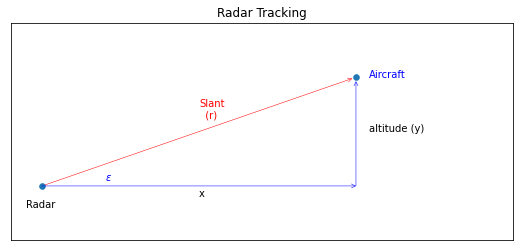

In [69]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_radar_chart()

The *elevation angle* $\epsilon$ is the angle above the line of sight formed by the ground.
>*仰角* $\epsilon$是地面形成的视线上方的角度。

We will assume that the aircraft is flying at a constant altitude. Thus we have a three variable state vector:
>我们假定飞机在一定高度飞行。因此我们有一个三个变量的状态向量:

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

The state transition function is linear 
>状态转移函数是线性的

$$\mathbf{\bar x} = \begin{bmatrix} 1 & \Delta t & 0 \\ 0& 1& 0 \\ 0&0&1\end{bmatrix}
\begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}
$$

and can be computed with:
>可以用以下方法计算:

In [70]:
def f_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft with state vector [x, velocity, altitude]'"""
    
    F = np.array([[1, dt, 0],
                  [0,  1, 0],
                  [0,  0, 1]], dtype=float)
    return F @ x

Next we design the measurement function. As in the linear Kalman filter the measurement function converts the filter's prior into a measurement. We need to convert the position and velocity of the aircraft into the elevation angle and range from the radar station.
>然后设计了测量功能。与线性卡尔曼滤波器一样，测量函数将滤波器的先验值转换为测量值。我们需要把飞机的位置和速度转换成从雷达站的仰角和距离。

Range is computed with the Pythagorean theorem:
>范围是用勾股定理计算的:

$$\text{range} = \sqrt{(x_\text{ac} - x_\text{radar})^2 + (y_\text{ac} - y_\mathtt{radar})^2}$$

The elevation angle $\epsilon$ is the arctangent of $y/x$:
> 仰角$\ = arctan ($y/x$):

$$\epsilon = \tan^{-1}{\frac{y_\mathtt{ac} - y_\text{radar}}{x_\text{ac} - x_\text{radar}}}$$

We need to define a Python function to compute this. I'll take advantage of the fact that a function can own a variable to store the radar's position. While this isn't necessary for this problem (we could hard code the value, or use a global), this gives the function more flexibility.

>我们需要定义一个Python函数来计算它。我将利用函数可以拥有一个变量来存储雷达位置这一事实。虽然这对于这个问题不是必需的(我们可以硬编码值，或者使用全局变量)，但这给函数提供了更多的灵活性。

In [71]:
def h_radar(x):
    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

There is a nonlinearity that we are not considering, the fact that angles are modular. The residual is the difference between the measurement and the prior projected into measurement space. The angular difference between 359° and 1° is 2°, but 359° - 1° = 358°. This is exacerbated by the UKF which computes sums of weighted values in the unscented transform. For now we will place our sensors and targets in positions that avoid these nonlinear regions. Later I will show you how to handle this problem.
>有一个我们没有考虑的非线性，角是模的。残差是测量值与之前投影到测量空间的差值。359°与1°的角度差为2°，而359°- 1°= 358°。这种情况被UKF加剧，UKF在无气味变换中计算加权值的总和。现在我们将把传感器和目标放置在避开这些非线性区域的位置。稍后我将向您展示如何处理这个问题。

We need to simulate the radar and the aircraft. By now this should be second nature for you, so I offer the code without discussion.
>我们需要模拟雷达和飞机。到目前为止，这应该是您的第二天性，所以我不进行讨论就提供了代码。

In [72]:
from numpy.linalg import norm
from math import atan2

class RadarStation:
    
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)       
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std

    
    def reading_of(self, ac_pos):
        """ Returns (range, elevation angle) to aircraft. 
        Elevation angle is in radians.
        """
        
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg


    def noisy_reading(self, ac_pos):
        """ Compute range and elevation angle to aircraft with 
        simulated noise"""
        
        rng, brg = self.reading_of(ac_pos)      
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std 
        return rng, brg       

class ACSim:   
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std        
        
    def update(self, dt):
        """ Compute and returns next position. Incorporates 
        random variation in velocity. """
        
        dx = self.vel*dt + (randn() * self.vel_std) * dt      
        self.pos += dx     
        return self.pos

A military grade radar achieves 1 meter RMS range accuracy, and 1 mrad RMS for elevation angle [1]. We will assume a more modest 5 meter range accuracy, and 0.5° angular accuracy as this provides a more challenging data set for the filter.
>军用级雷达达到1米RMS距离精度，俯仰角[1]的RMS为1 mrad。我们将假设一个更适中的5米范围精度和0.5°角精度，因为这为过滤器提供了一个更具挑战性的数据集。

The design of $\mathbf Q$ requires some discussion. The state is $\begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$. The first two elements are down range distance and velocity, so we can use `Q_discrete_white_noise` noise to compute the values for the upper left hand side of Q. The third element is altitude, which we assume is independent of $x$. That results in a block design for $\mathbf Q$:
>$\mathbf Q$的设计需要一些讨论。状态为$\begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$。前两个元素是向下的距离和速度，所以我们可以使用' Q_discrete_white_noise '噪声来计算q左上角的值。第三个元素是海拔，我们假设它与$x$无关。这将导致$\mathbf Q$的块设计:

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & \boldsymbol 0 \\ \boldsymbol 0 & Q_\mathtt{y}\end{bmatrix}$$

I'll start with the aircraft positioned directly over the radar station, flying at 100 m/s. A typical height finder radar might update only once every 3 seconds so we will use that for our epoch period. 
>我将从位于雷达站正上方的飞机开始，以每秒100米的速度飞行。一个典型的测高仪雷达可能每3秒更新一次，所以我们将使用它作为我们的纪元周期。

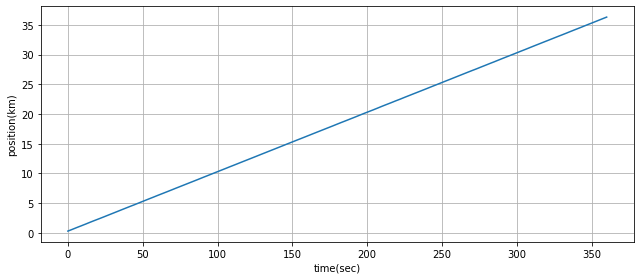

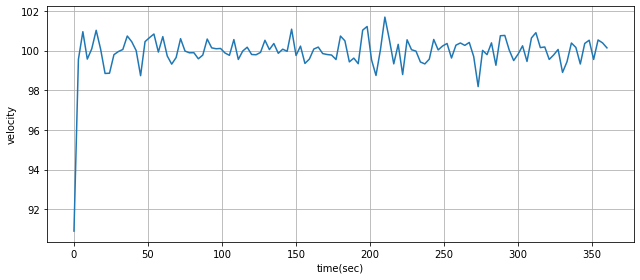

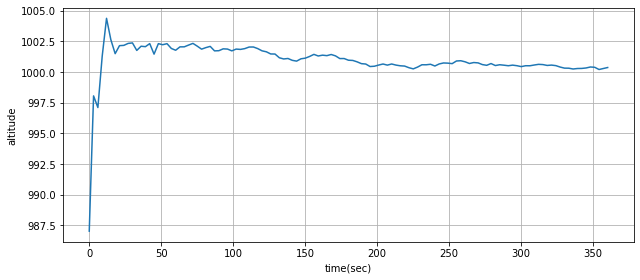

In [73]:
import math
from kf_book.ukf_internal import plot_radar

dt = 3. # 12 seconds between readings
range_std = 5 # meters
elevation_angle_std = math.radians(0.5)
ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2,2] = 0.1

kf.R = np.diag([range_std**2, elevation_angle_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)    
plot_radar(xs, time)

This may or may not impress you, but it impresses me! In the Extended Kalman filter chapter we will solve the same problem, but it will take a significant amount of mathematics. 
>这可能会让你刮目相看，也可能不会，但它会让我刮目相看!在扩展卡尔曼滤波一章中，我们将解决同样的问题，但这将需要大量的数学知识。

### 跟踪Maneuevering飞机

The previous example produced good results, but it assumed the aircraft did not change altitude. Here are the filter results if the aircraft starts climbing after one minute.
>前一个例子产生了良好的结果，但它假设飞机没有改变高度。这是一分钟后飞机开始爬升时的过滤结果。

Actual altitude: 2515.6
UKF altitude   : 1042.1


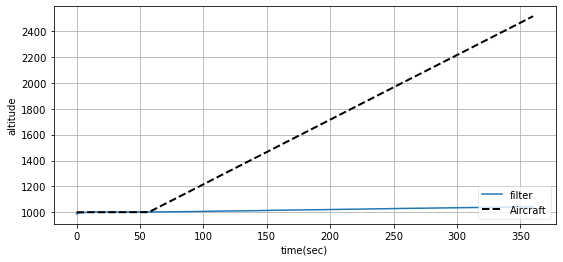

In [74]:
from kf_book.ukf_internal import plot_altitude

# reset aircraft position
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf.predict()
    kf.update([r[0], r[1]]) 
    xs.append(kf.x)

plot_altitude(xs, time, ys)
print(f'Actual altitude: {ac.pos[1]:.1f}')
print(f'UKF altitude   : {xs[-1][2]:.1f}')

The filter is unable to track the changing altitude. What do we have to change in our design?
>过滤器无法跟踪变化的高度。我们的设计有什么需要改变的?

I hope you answered "add climb rate to the state", like so:
>我希望你回答的是“add climb rate to the state”，像这样:


$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude} \\ \mathtt{climb\, rate}\end{bmatrix}=  \begin{bmatrix}x \\\dot x\\ y \\ \dot y\end{bmatrix}$$

This requires the following change to the state transition function, which is still linear.
>这需要对状态转移函数进行以下更改，状态转移函数仍然是线性的。

$$\mathbf{F} = \begin{bmatrix} 1 & \Delta t & 0 &0 \\ 0& 1& 0 &0\\ 0&0&1&\Delta t \\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\\dot x\\ y\\ \dot y\end{bmatrix} 
$$

The measurement function stays the same, but we must alter $\mathbf Q$ to account for the dimensionality change of $\mathbf x$.
>测量函数保持不变，但我们必须改变$\mathbf Q$，以解释$\mathbf x$的维数变化。

In [75]:
def f_cv_radar(x, dt):
    """ state transition function for a constant velocity 
    aircraft"""
    F = np.array([[1, dt, 0, 0],
                  [0,  1, 0, 0],
                  [0,  0, 1, dt],
                  [0,  0, 0, 1]], dtype=float)
    return F @ x
    
def cv_UKF(fx, hx, R_std):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)
    kf = UKF(4, len(R_std), dt, fx=fx, hx=hx, points=points)

    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.R = np.diag(R_std)
    kf.R = kf.R @ kf.R  # square to get variance
    kf.x = np.array([0., 90., 1100., 0.])
    kf.P = np.diag([300**2, 3**2, 150**2, 3**2])
    return kf

Actual altitude: 2515.6
UKF altitude   : 2500.1


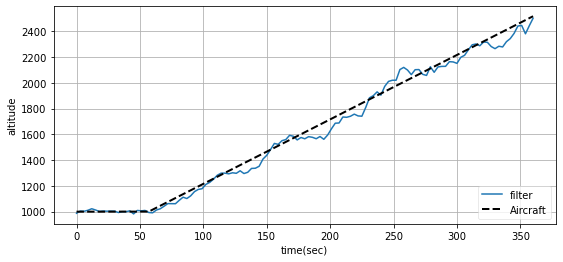

In [76]:
np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_cv = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf_cv.predict()
    kf_cv.update([r[0], r[1]]) 
    xs.append(kf_cv.x)

plot_altitude(xs, time, ys)
print(f'Actual altitude: {ac.pos[1]:.1f}')
print(f'UKF altitude   : {xs[-1][2]:.1f}')

A significant amount of noise has been introduced into the altitude estimate, but we are now accurately tracking altitude.
>在高度估计中引入了大量的噪声，但我们现在正在准确地跟踪高度。

### 传感器融合

Now let's consider an example of sensor fusion. We have some type of Doppler system that produces a velocity estimate with 2 m/s RMS accuracy. I say "some type" because as with the radar I am not trying to teach you how to create an accurate filter for a Doppler system. A full implementation must account for the signal to noise ratio, atmospheric effects, the geometry of the system, and so on. 
>现在让我们考虑一个传感器融合的例子。我们有某种类型的多普勒系统，它产生的速度估计的RMS精度为2米/秒。我说“某种类型”，因为与雷达一样，我不是试图教你如何为多普勒系统创建一个精确的过滤器。一个完整的实现必须考虑到信噪比，大气影响，系统的几何形状，等等。

The radar's accuracy in the last examples allowed us to estimate velocities to within one m/s or so, I will degrade that accuracy to illustrate the effect of sensor fusion. Let's change the range error to $\sigma=500$ meters and then compute the standard deviation of the estimated velocity. I'll skip the first several measurements because the filter is converging during that time, causing artificially large deviations.
>最后一个例子中的雷达精度允许我们估计速度在1m /s左右，我将降低这个精度来说明传感器融合的效果。让我们将范围误差改为$\sigma=500$米，然后计算估计速度的标准偏差。我将跳过前几个测量，因为在此期间滤波器会收敛，造成人为的大偏差。

The standard deviation without using Doppler is:
>不使用多普勒的标准差为:

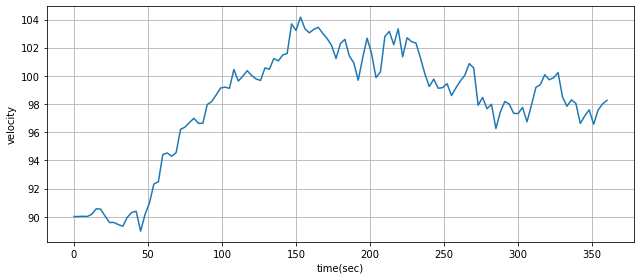

Velocity std 3.4 m/s


In [77]:
range_std = 500.
elevation_angle_std = math.degrees(0.5)
np.random.seed(200)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_sf = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs = []
for _ in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    kf_sf.predict()
    kf_sf.update([r[0], r[1]]) 
    xs.append(kf_sf.x)

xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)
print(f'Velocity std {np.std(xs[10:, 1]):.1f} m/s')

For Doppler we need to include the velocity in $x$ and $y$ into the measurement. The `ACSim` class stores velocity in the data member `vel`. To perform the Kalman filter update we just need to call `update` with a list containing the slant distance, elevation angle, and velocity in $x$ and $y$:
>对于多普勒，我们需要将$x$和$y$中的速度包含到测量中。“ACSim”类将速度存储在数据成员“vel”中。为了执行卡尔曼滤波更新，我们只需要调用一个包含倾斜距离、仰角和速度的列表' update '，单位为$x$和$y$:

$$z = [\mathtt{slant\_range},\, \text{elevation angle},\, \dot x,\, \dot y]$$

The measurement contains four values so the measurement function also needs to return four values. The slant range and elevation angle will be computed as before, and we do not need to compute the velocity in $x$ and $y$ as they are provided by the state estimate.
>测量包含四个值，因此测量函数也需要返回四个值。倾斜距离和仰角将像以前一样计算，我们不需要计算$x$和$y$的速度，因为它们是由状态估计提供的。

In [78]:
def h_vel(x):
    dx = x[0] - h_vel.radar_pos[0]
    dz = x[2] - h_vel.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dz**2)
    elevation_angle = math.atan2(dz, dx)
    return slant_range, elevation_angle, x[1], x[3]

Now we can implement our filter.
现在我们可以实现过滤器了。

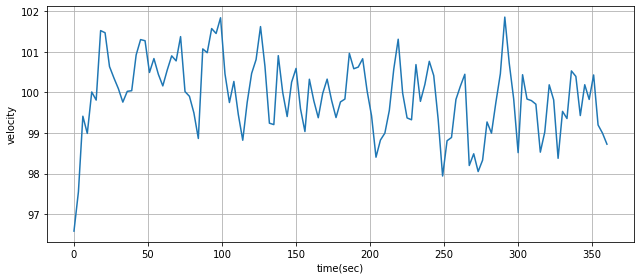

Velocity std 0.9 m/s


In [79]:
h_radar.radar_pos = (0, 0)
h_vel.radar_pos = (0, 0)

range_std = 500.
elevation_angle_std = math.degrees(0.5)
vel_std = 2.

np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)
radar = RadarStation((0, 0), range_std, elevation_angle_std)

kf_sf2 = cv_UKF(f_cv_radar, h_vel, 
            R_std=[range_std, elevation_angle_std, vel_std, vel_std])

time = np.arange(0, 360 + dt, dt)
xs = []
for t in time:
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    # simulate the doppler velocity reading
    vx = ac.vel[0] + randn()*vel_std
    vz = ac.vel[1] + randn()*vel_std
    kf_sf2.predict()
    kf_sf2.update([r[0], r[1], vx, vz]) 
    xs.append(kf_sf2.x)
xs = np.asarray(xs)
plot_radar(xs, time, plot_x=False, plot_vel=True, plot_alt=False)
print(f'Velocity std {np.std(xs[10:,1]):.1f} m/s')

By incorporating the velocity sensor we were able to reduce the standard deviation from 3.5 m/s to 1.3 m/s. 
>通过加入速度传感器，我们能够将标准偏差从3.5米/秒减少到1.3米/秒。

Sensor fusion is a large topic, and this is a rather simplistic implementation. In a typical navigation problem we have sensors that provide *complementary* information. For example, a GPS might provide somewhat accurate position updates once a second with poor velocity estimation while an inertial system might provide very accurate velocity updates at 50Hz but terrible position estimates. The strengths and weaknesses of each sensor are orthogonal to each other. This leads to the *Complementary filter*, which blends the high update rate inertial velocity measurements with the accurate but slowly updated position estimates of the GPS to produce  high rate and accurate position and velocity estimates. The high rate velocity estimates are integrated between the GPS updates to produce accurate and high rate position estimates.
>传感器融合是一个大的主题，而这是一个相当简单的实现。在一个典型的导航问题中，我们有提供“互补”信息的传感器。例如，GPS可能每秒提供一次比较精确的位置更新，但速度估计很差，而惯性系统可能以50Hz提供非常精确的速度更新，但位置估计很差。各传感器的优缺点是相互正交的。这导致了*互补滤波器*，它将高更新率的惯性速度测量与GPS精确但缓慢更新的位置估计相结合，以产生高速率和准确的位置和速度估计。在GPS更新之间集成高速速度估计，以产生准确和高速率的位置估计。

### 多个位置传感器

The last sensor fusion problem was a toy example. Let's tackle a problem that is not so toy-like. Before GPS ships and aircraft navigated via various range and bearing systems such as VOR, LORAN, TACAN, DME, and so on. These systems emit beacons in the form of radio waves. The sensor extracts the range and/or bearing to the beacon from the signal. For example, an aircraft might have two VOR receivers. The pilot tunes each receiver to a different VOR station. Each VOR receiver displays the *radial* - the direction from the VOR station on the ground to the aircraft. The pilot uses a chart to find the intersection point of the radials, which identifies the location of the aircraft.
>最后一个传感器融合问题是一个玩具例子。让我们来解决一个不那么简单的问题。在GPS之前，船舶和飞机通过各种距离和方位系统导航，如VOR、LORAN、TACAN、DME等。这些系统以无线电波的形式发射信标。传感器从信号中提取到信标的距离和/或方位。例如，一架飞机可能有两个VOR接收机。飞行员将每个接收器调到不同的VOR台。每个VOR接收机都显示从地面VOR台到飞机的“径向”方向。飞行员使用图表来找到这些径向线的交点，从而确定飞机的位置。

That is a manual approach with low accuracy. A Kalman filter will produce far more accurate position estimates. Assume we have two sensors, each of which provides a bearing only measurement to the target, as in the chart below. The width of the perimeters are proportional to the $3\sigma$ of the sensor noise. The aircraft must be positioned somewhere within the intersection of the two perimeters with a high degree of probability.
>这是一种人工方法，精度很低。卡尔曼滤波器将产生精确得多的位置估计。假设我们有两个传感器，每个传感器都提供了对目标的测量，如下图所示。周长的宽度与传感器噪声的$3\sigma$成正比。飞机必须被放置在两个周长交点的某个高度有可能的地方。

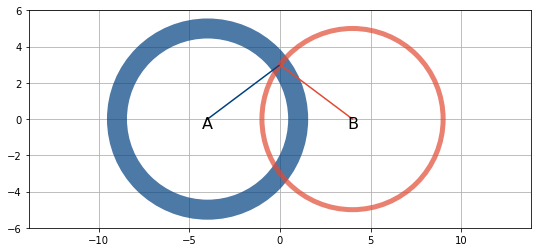

In [80]:
ukf_internal.show_two_sensor_bearing()

We compute the bearing between a sensor and the target as:
>我们计算传感器与目标之间的方位为:

In [81]:
def bearing(sensor, target_pos):
    return math.atan2(target_pos[1] - sensor[1], 
                      target_pos[0] - sensor[0])

The filter receives the measurement from the two sensors in a vector. The code will accept any iterable container, so I use a Python list for efficiency. We can implement that as:
>滤波器以矢量形式接收两个传感器的测量值。代码将接受任何可迭代容器，因此为了提高效率，我使用了Python列表。我们可以这样实现:

In [82]:
def measurement(A_pos, B_pos, pos):
    angle_a = bearing(A_pos, pos)
    angle_b = bearing(B_pos, pos)
    return [angle_a, angle_b]

Assume a constant velocity model for the aircraft. For a change of pace I compute the new positions explicitly rather than using matrix-vector multiplication:
>假设飞机的速度是恒定的。为了改变速度，我显式地计算新位置，而不是使用矩阵向量乘法:

In [83]:
def fx_VOR(x, dt):
    x[0] += x[1] * dt
    x[2] += x[3] * dt
    return x

Next we implement the measurement function. It converts the prior to an array containing the measurement to both stations. I'm not a fan of global variables, but I put the position of the stations in the global variables `sa_pos` and `sb_pos` to demonstrate this method of sharing data with $h()$:
>接下来我们实现测量功能。它将先验转换为包含测量值的阵列到两个站。我不是一个全局变量的粉丝，但我把站的位置在全局变量' sa_pos '和' sb_pos '，以演示这种方法共享数据的$h()$:

In [84]:
sa_pos = [-400, 0]
sb_pos = [400, 0]

def hx_VOR(x):
    # measurement to A
    pos = (x[0], x[2])
    return measurement(sa_pos, sb_pos, pos)

Now we write boilerplate which constructs the filter, runs it, and plots the results:
>现在，我们编写构建过滤器的样板文件，运行它，并绘制结果:

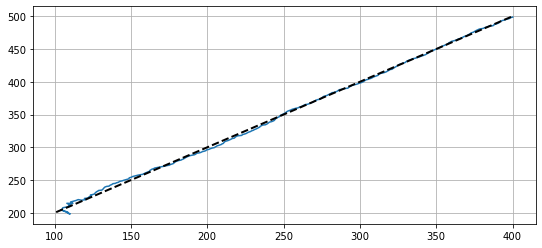

In [85]:
def moving_target_filter(pos, std_noise, Q, dt=0.1, kappa=0.0):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=kappa)
    f = UKF(dim_x=4, dim_z=2, dt=dt, 
            hx=hx_VOR, fx=fx_VOR, points=points)
    f.x = np.array([pos[0], 1., pos[1], 1.])

    q = Q_discrete_white_noise(2, dt, Q)
    f.Q[0:2, 0:2] = q
    f.Q[2:4, 2:4] = q
    f.R *= std_noise**2
    f.P *= 1000    
    return f

def plot_straight_line_target(f, std_noise):
    xs, txs = [], []
    for i in range(300):
        target_pos[0] += 1 + randn()*0.0001
        target_pos[1] += 1 + randn()*0.0001
        txs.append((target_pos[0], target_pos[1]))

        z = measurement(sa_pos, sb_pos, target_pos)
        z[0] += randn() * std_noise
        z[1] += randn() * std_noise

        f.predict()
        f.update(z)
        xs.append(f.x)

    xs = np.asarray(xs)
    txs = np.asarray(txs)

    plt.plot(xs[:, 0], xs[:, 2])
    plt.plot(txs[:, 0], txs[:, 1], ls='--', lw=2, c='k')
    plt.show()

np.random.seed(123)
target_pos = [100, 200]

std_noise = math.radians(0.5)
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

This looks quite good to me. The beginning of the track exhibits large errors, but the filter settles down and produces good estimates.
>我觉得这个不错。轨迹的开始显示出很大的误差，但是过滤器稳定下来并产生良好的估计。

Let's revisit the nonlinearity of the angles. I will position the target between the two sensors at (0,0). This will cause a nonlinearity in the computation of the residuals because the mean angle will be near zero. As the angle goes below 0 the measurement function will compute a large positive angle of nearly $2\pi$. The residual between the prediction and measurement will thus be very large, nearly $2\pi$ instead of nearly 0. This makes it impossible for the filter to perform accurately, as seen in the example below.
>我们再来看看角度的非线性。我将目标定位在(0,0)两个传感器之间。这将导致残差计算的非线性，因为平均角度将接近于零。当角度低于0时，测量函数将计算出一个接近$2\pi$的大正值角度。因此，预测和测量之间的残差将非常大，接近$2\pi$而不是接近0。这使得过滤器无法准确执行，如下面的示例所示。

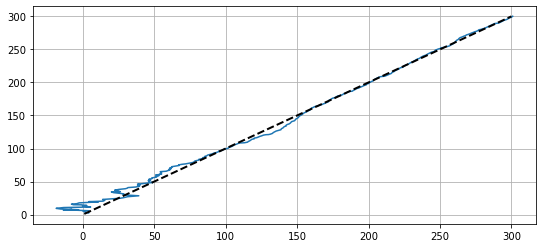

In [86]:
target_pos = [0, 0]
f = moving_target_filter(target_pos, std_noise, Q=1.0)
plot_straight_line_target(f, std_noise)

This performance is unacceptable. `FilterPy`'s UKF code allows you to specify a function which computes the residuals in cases of nonlinear behavior like this,. The final example in this chapter demonstrates its use.
>这种表现令人无法接受。FilterPy的UKF代码允许你指定一个函数来计算像这样的非线性行为的残差。本章的最后一个例子演示了它的用法。

## 传感器误差和几何形状的影响

The geometry of the sensors relative to the tracked object imposes a physical limitation that can be extremely difficult to deal with when designing filters. If the radials of the VOR stations are nearly parallel to each other then a very small angular error translates into a very large distance error. What is worse, this behavior is nonlinear - the error in the *x-axis* vs the *y-axis* will vary depending on the actual bearing. These scatter plots  show the error distribution for a 1°$\sigma$ error for two different bearings.
>传感器相对于跟踪对象的几何形状施加了一个物理限制，在设计滤波器时可能非常难以处理。如果VOR台站的径向几乎是相互平行的，那么一个非常小的角度误差就会转化为非常大的距离误差。更糟糕的是，这种行为是非线性的- *x轴*与*y轴*的误差将根据实际轴承而变化。这些散点图显示了两个不同轴承的1°$\sigma$误差的误差分布。

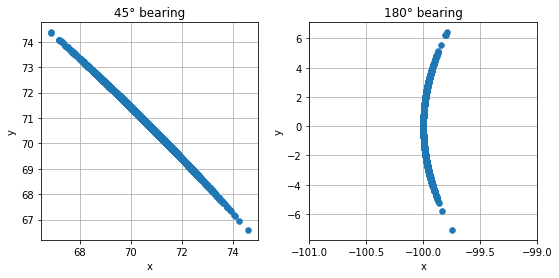

In [87]:
ukf_internal.plot_scatter_of_bearing_error()

## 练习:解释过滤性能

We can see that for small angular errors the positional errors are very large. Explain how we got such relatively good performance out of the UKF in the target tracking problems above. Answer for both the one sensor and multiple sensor problem. 
>我们可以看到，对于小的角误差，位置误差是非常大的。解释一下我们是如何在上面的目标跟踪问题中得到UKF相对较好的性能的。解决一个传感器和多个传感器的问题。

### 解决方案

This is very important to understand. Try very hard to answer this before reading the answer below. If you cannot answer this you may need to revisit some of the earlier material in the **Multidimensional Kalman Filter** chapter.
>理解这一点非常重要。在阅读下面的答案之前，努力回答这个问题。如果你不能回答这个问题，你可能需要重新阅读**多维卡尔曼滤波一章中的一些早期材料。

There are several factors contributing to our success. First, let's consider the case of having only one sensor. Any single measurement has an extreme range of possible positions. But, our target is moving, and the UKF is taking that into account. Let's plot the results of several measurements taken in a row for a moving target.
>有几个因素促成了我们的成功。首先，让我们考虑只有一个传感器的情况。任何单一的测量都有一个极端的可能位置范围。但是，我们的目标在移动，英国空军正在考虑这一点。让我们绘制一个移动目标的连续几次测量的结果。

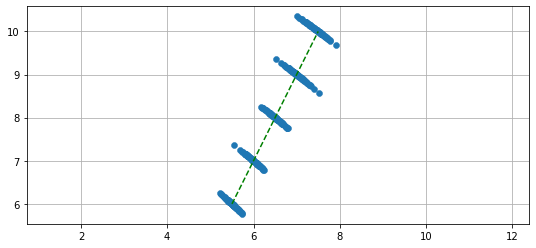

In [88]:
ukf_internal.plot_scatter_moving_target()

Each individual measurement has a very large position error. However, a plot of successive measurements shows a clear trend - the target is obviously moving towards the upper right. When a Kalman filter computes the Kalman gain it takes the distribution of errors into account by using the measurement function. In this example the error lies on an approximately 45° line, so the filter will discount errors in that direction. On the other hand, there is almost no error in measurement orthogonal to that, and again the Kalman gain will take that into account. 
>每次测量都有很大的位置误差。然而，连续测量的图显示了一个明显的趋势——目标明显地向右上方移动。当卡尔曼滤波器计算卡尔曼增益时，它利用测量函数考虑误差的分布。在这个例子中，误差位于一个大约45°的直线上，所以过滤器将在那个方向上忽略误差。另一方面，与它正交的测量几乎没有误差，卡尔曼增益也会考虑到这一点。

This graph makes it look easy because we have plotted 100 measurements for each position update. The movement of the aircraft is obvious. In contrast, the Kalman filter only gets one measurement per update. Therefore the filter will not be able to generate as good a fit as the dotted green line implies. 
>这个图看起来很简单，因为我们为每个位置更新绘制了100个测量值。飞机的运动很明显。相比之下，卡尔曼滤波器每次更新只得到一个测量值。因此，过滤器将不能生成像虚线绿线所暗示的那样好的拟合。

Now consider that the bearing gives us no distance information. Suppose we set the initial estimate to 1,000 kilometers away from the sensor (vs the actual distance of 7.07 km) and make $\mathbf P$ very small. At that distance a 1° error translates into a positional error of 17.5 km. The KF would never be able to converge onto the actual target position because the filter is incorrectly very certain about its position estimates and because there is no distance information provided in the measurements.
>现在考虑轴承没有给我们距离信息。假设我们将初始估计设为距离传感器1000公里(而实际距离为7.07公里)，并使$\mathbf P$非常小。在这个距离上，1°误差转化为17.5 km的位置误差。KF永远不能收敛到实际的目标位置，因为滤波器不正确地非常确定其位置估计，因为在测量中没有提供距离信息。

Now let's consider the effect of adding a second sensor. Here are two plots showing the effects of different sensor placements. I used a square and a triangle as a symbol for the two sensors, and drew a distribution of the errors due to each sensor using the same symbol shape and color. I then computed the $(x, y)$ coordinate corresponding to the two noisy bearing measurements and plotted them with red dots to show the distribution of the noisy measurements in $x$ and $y$.
>现在让我们考虑添加第二个传感器的效果。这里有两个图显示了不同传感器位置的影响。我用一个正方形和一个三角形作为两个传感器的符号，并用相同的符号形状和颜色绘制了每个传感器的误差分布。然后我计算了$(x, y)$坐标，对应于两个噪声轴承测量值，并用红点绘制它们，以显示在$x$和$y$中噪声测量值的分布。

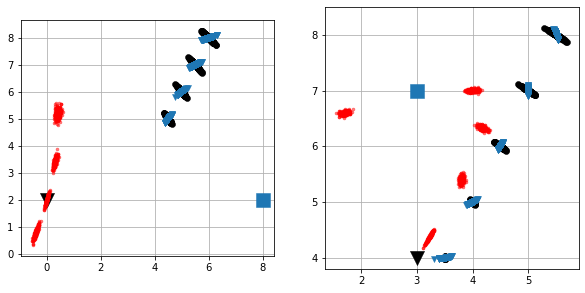

In [89]:
with figsize(10,5):
    ukf_internal.plot_iscts_two_sensors()

In the first plot I placed the sensors nearly orthogonal to the target's initial position so we get these lovely 'x' shape intersections. We can see how the errors in $x$ and $y$ change as the target moves by the shape the scattered red dots make - as the target gets further away from the sensors, but nearer the $y$ coordinate of sensor B the shape becomes strongly elliptical.
>在第一张图中，我将传感器与目标的初始位置几乎垂直，所以我们得到了这些可爱的“x”形状的交点。通过散射红点的形状，我们可以看到随着目标的移动，$x$和$y$的误差是如何变化的——随着目标离传感器越来越远，但离传感器B的$y$坐标越来越近，形状就变成了强烈的椭圆。

In the second plot the airplane starts very near one sensor, and then flies past the second sensor. The intersections of the errors are very non-orthogonal, and the resulting position errors become very spread out.
>在第二幅图中，飞机在一个传感器附近开始飞行，然后飞过第二个传感器。这些误差的交点是非正交的，由此产生的位置误差非常分散。

## UKF的实现

FilterPy implements the UKF, but it is instructive to learn how to translate equations into code. Implementing the UKF is quite straightforward. First, let's write code to compute the mean and covariance of the sigma points. 
>FilterPy实现了UKF，但是学习如何将等式转换为代码很有意义。实现UKF非常简单。首先，让我们编写代码来计算点的均值和协方差。

We will store the sigma points and weights in matrices, like so:
>我们将把点和权值存储在矩阵中，像这样:

$$ 
\begin{aligned}
\text{weights} &= 
\begin{bmatrix}
w_0& w_1 & \dots & w_{2n}
\end{bmatrix} 
\\
\text{sigmas} &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} & \dots & \mathcal{X}_{0,n-1} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \dots & \mathcal{X}_{1,n-1} \\
\vdots & \vdots &  \ddots & \vdots \\
\mathcal{X}_{2n,0} & \mathcal{X}_{2n,1} & \dots & \mathcal{X}_{2n,n-1}
\end{bmatrix}
\end{aligned}
$$


That's a lot of subscripts to describe something very simple, so here's an example for a two dimensional problem ($n$=2):
>用这么多下标来描述一个非常简单的东西，这里有一个二维问题($n$=2)的例子:

In [90]:
points = MerweScaledSigmaPoints(n=2, alpha=.1, beta=2., kappa=1.)
points.sigma_points(x=[0.,0], P=[[1.,.1],[.1, 1]])

array([[ 0.   ,  0.   ],
       [ 0.173,  0.017],
       [ 0.   ,  0.172],
       [-0.173, -0.017],
       [ 0.   , -0.172]])

The sigma point for the mean is on the first row.  Its position is (0, 0), which is equal to the mean (0,0). The second sigma point is at position (0.173, 0.017), and so on. There are are $2n+1 = 5$ rows, one row per sigma point. If $n=3$, then there would be 3 columns and 7 rows.
>均值的点在第一行。它的位置是(0,0)等于均值(0,0)第二个西格玛点在位置(0.173,0.017)，以此类推。有$2n+1 = 5$行，每个点一行。如果$n=3$，则有3列7行。

The choice to store the sigmas in row-column vs column row format is somewhat arbitrary; my choice makes the rest of the code clearer as I can refer to the i$^{th}$ sigma point as `sigmas[i]` instead of `sigmas[:, i]`.
>选择以行-列和列-行格式存储σ多少是任意的;我的选择使其余的代码更清晰，因为我可以将I $^{th}$ sigma点表示为' sigma [I] '而不是' sigma [:， I] '。

### 权重

Computing the weights with NumPy is easy. Recall that the Van der Merwe scaled sigma point implementation states:
>使用NumPy计算权重很容易。回想一下Van der Merwe缩放西格玛点的实现状态:

$$
\begin{aligned}
\lambda&=\alpha^2(n+\kappa)-n \\ 
W^m_0 &= \frac{\lambda}{n+\lambda} \\
W^c_0 &= \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta \\
W^m_i = W^c_i &= \frac{1}{2(n+\lambda)}\;\;\;i=1..2n
\end{aligned}
$$
    
Code for these is:
>这些代码是:

```python
lambda_ = alpha**2 * (n + kappa) - n
Wc = np.full(2*n + 1,  1. / (2*(n + lambda_))
Wm = np.full(2*n + 1,  1. / (2*(n + lambda_))
Wc[0] = lambda_ / (n + lambda_) + (1. - alpha**2 + beta)
Wm[0] = lambda_ / (n + lambda_)
```

I use the underscore in `lambda_` because `lambda` is a reserved word in Python. A trailing underscore is the Pythonic workaround.
>我在' lambda_ '中使用下划线，因为' lambda '在Python中是一个保留字。末尾下划线是python的解决方案。

### Sigma 点

The equations for the sigma points are:
>点的方程是:

$$
\begin{cases}
\mathcal{X}_0 = \mu \\
\mathcal{X}_i = \mu +  \left[\sqrt{(n+\lambda)\Sigma} \right]_i, & \texttt{for i=1..n} \\
\mathcal{X}_i = \mu - \left[\sqrt{(n+\lambda)\Sigma}\right]_{i-n} & \texttt{for i=(n+1)..2n}
\end{cases}
$$

The Python is not difficult once we understand the $\left[\sqrt{(n+\lambda)\Sigma}  \right]_i$ term.
>一旦理解了$\left[\sqrt{(n+\lambda)\Sigma} \right]_i$项，Python就不难理解了。

The term $\sqrt{(n+\lambda)\Sigma}$ is a matrix because $\Sigma$ is a matrix. The subscript $i$ in $[\sqrt{(n+\lambda)\Sigma}]_i$ is choosing the i-th row vector of the matrix. What is the square root of a matrix? There is no unique definition. One definition is that the square root of a matrix $\Sigma$ is the matrix $S$ that, when multiplied by itself, yields $\Sigma$: if  $\Sigma = SS$ then $S = \sqrt{\Sigma}$.

>$\sqrt{(n+\lambda)\Sigma}$是一个矩阵，因为 $\Sigma$是一个矩阵。$[\sqrt{(n+\lambda)\Sigma}]_i$中的下标$i$是选择矩阵的第i行向量。一个矩阵的平方根是什么?没有唯一的定义。一种定义是，矩阵$\Sigma$的平方根是矩阵$S$，当矩阵$S$与自身相乘时，得到$\Sigma$:如果$\Sigma$ = SS$，则$S = sqrt{\Sigma}$。

We will choose an alternative definition that has numerical properties which make it easier to compute. We can define the square root as the matrix S, which when multiplied by its transpose, returns $\Sigma$:
>我们将选择另一种定义，它具有数值性质，使其更容易计算。我们可以定义平方根为矩阵S，当乘以它的转置，返回$\Sigma$:

$$
\Sigma = \mathbf{SS}^\mathsf T
$$

This definition is favored because $\mathbf S$ is computed using the [*Cholesky decomposition*](https://en.wikipedia.org/wiki/Cholesky_decomposition) [3]. It decomposes a Hermitian, positive-definite matrix into a triangular matrix and its conjugate transpose. The matrix can be either upper 
or lower triangular, like so:
>这个定义很受欢迎，因为$\mathbf S$是使用[*Cholesky分解*](https://en.wikipedia.org/wiki/Cholesky_decomposition)[3]计算的。它把一个厄米正定矩阵分解成一个三角矩阵及其共轭转置。矩阵可以是上三角形，也可以是下三角形，像这样:

$$A=LL^{∗} \\ A=U^{∗}U$$

The asterick denotes the conjugate transpose; we have only real numbers so for us we can write:
>星号表示共轭转置;我们只有真实的数字，所以我们可以写:

$$A=LL^\mathsf T \\ A=U^\mathsf T U$$

$\mathbf P$ has these properties, so we can treat $\mathbf S = \text{cholesky}(\mathbf P)$ as the square root of $\mathbf P$.
>$ mathbf P$具有这些属性，所以我们可以将$ mathbf S = \text{cholesky}(\mathbf P)$看作$ mathbf P$的平方根。

SciPy provides `cholesky()` method in `scipy.linalg`. If your language of choice is Fortran, C, or C++, libraries such as LAPACK provide this routine. Matlab provides `chol()`.
>SciPy在' SciPy .linalg '中提供' cholesky() '方法。如果您选择的语言是Fortran、C或c++，像LAPACK这样的库就提供了这个例程。Matlab提供的胆固醇()”。

By default `scipy.linalg.cholesky()` returns a upper triangular matrix, so I elected to write the code to expect an upper triangular matrix. For this reason I access the result by row, so that the first sigma point, which is the center point, is affected by a full row of non-zero values.  If you provide your own square root implementation you will need to take this into account. You will find UKF algorithms in the literature that take the values column first. This is fine if the cholesky is lower-triangular, or if you are using a different algorithm that computes a symmetric matrix so row vs column order doesn't matter. 

>默认情况下' scipy. linalgl .cholesky() '返回一个上三角矩阵，所以我选择编写代码以期望得到一个上三角矩阵。由于这个原因，我按行访问结果，所以第一个点，也就是中心点，受到整行非零值的影响。如果您提供自己的平方根实现，则需要考虑到这一点。您可以在文献中找到首先取values列的UKF算法。如果cholesky是下三角形，或者你用了另一种算法来计算对称矩阵，那么行与列的顺序无关。

In [91]:
import scipy
a = np.array([[2., .1], [.1, 3]])
s = scipy.linalg.cholesky(a)
print("cholesky:")
print(s)
print("\nsquare of cholesky:")
print(s @ s.T)

cholesky:
[[1.414 0.071]
 [0.    1.731]]

square of cholesky:
[[2.005 0.122]
 [0.122 2.995]]


So we can implement the sigma points with this code:
>我们可以用下面的代码来实现点

```python
sigmas = np.zeros((2*n+1, n))
U = scipy.linalg.cholesky((n+lambda_)*P) # sqrt

sigmas[0] = X
for k in range (n):
    sigmas[k+1]   = X + U[k]
    sigmas[n+k+1] = X - U[k]
```

Now let's implement the unscented transform. Recall the equations
>现在让我们实现无味的转换。回忆的方程

$$\begin{aligned}
\mu &= \sum_i w_i^m\mathcal{X}_i \\
\Sigma &= \sum_i w_i^c{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}}
\end{aligned}
$$

We implement the sum of the means with
>我们实现的是均值的和

```python
x = np.dot(Wm, sigmas)
```

If you are not a heavy user of NumPy this may look foreign to you. NumPy is not just a library that make linear algebra possible; under the hood it is written in C and Fortran to achieve much faster speeds than Python can reach. A typical speedup is 20x to 100x. To get that speedup we must avoid using for loops, and instead use NumPy's built in functions to perform calculations. So, instead of writing a for loop to compute the sum of products, we call the built in `numpy.dot(x, y)` method. The dot product of two vectors is the sum of the element-wise multiplications of each element. If passed a 1D array and a 2D array it will compute the sum of inner products:
>如果你不是NumPy的忠实用户，这对你来说可能很陌生。NumPy不仅仅是一个使线性代数成为可能的库;在底层，它是用C和Fortran编写的，以达到比Python更快的速度。一个典型的加速是20到100倍。为了获得这种加速，我们必须避免使用for循环，而是使用NumPy的内置函数来执行计算。所以，我们不是写一个for循环来计算乘积的和，而是调用内建的numpy。点(x, y)方法。两个向量的点积是每个元素的乘积之和。如果传入一个1D数组和一个2D数组，它将计算内积的和:

In [92]:
a = np.array([10, 100])
b = np.array([[1, 2, 3],
              [4, 5, 6]])
np.dot(a, b)

array([410, 520, 630])

剩下的就是计算了 $\mathbf P = \sum_i w_i{(\mathcal{X}_i-\mu)(\mathcal{X}_i-\mu)^\mathsf{T}} + \mathbf Q$:

```python
kmax, n = sigmas.shape
P = zeros((n, n))
for k in range(kmax):
    y = sigmas[k] - x
    P += Wc[k] * np.outer(y, y) 
P += Q
```

This introduces another feature of NumPy. The state variable `x` is one dimensional, as is `sigmas[k]`, so the difference `sigmas[k]-X` is also one dimensional. NumPy will not compute the transpose of a 1-D array; it considers the transpose of `[1,2,3]` to be `[1,2,3]`. So we call the function `np.outer(y,y)` which computes the value of $\mathbf{yy}^\mathsf{T}$ for the 1D array $\mathbf{y}$. An alternative implementation could be:
>这引入了NumPy的另一个特性。状态变量' x '是一维的，' sigmas[k] '也是，所以' sigmas[k]-X '也是一维的。NumPy不会计算一维数组的转置;它认为'[1,2,3]'的转置为'[1,2,3]'。因此，我们调用函数' np.outer(y,y) '，它为一维数组$ mathbf{y}$计算$\mathbf{yy}^\mathsf{T}$的值。另一种实现方式是:

```python
y = (sigmas[k] - x).reshape(kmax, 1) # convert into 2D array
P += Wc[K] * np.dot(y, y.T)
```

This code is slower and not idiomatic, so we will not use it.
>这段代码速度较慢，而且不符合习惯用法，所以我们不使用它。

### 预测步骤

For the predict step, we will generate the weights and sigma points as specified above. We pass each sigma point through the function f.
>对于预测步骤，我们将生成如上所述的权重和sigma点。每个点都通过函数f。

$$\boldsymbol{\mathcal{Y}} = f(\boldsymbol{\chi})$$

Then we compute the predicted mean and covariance using the unscented transform. In the code below you can see that I am assuming that this is a method in a class that stores the various matrices and vectors needed by the filter.
>然后利用无迹变换计算预测均值和协方差。在下面的代码中，您可以看到我假设这是一个类中的方法，它存储了过滤器所需的各种矩阵和向量。

```python
def predict(self, sigma_points_fn):
    """ Performs the predict step of the UKF. On return, 
    self.xp and self.Pp contain the predicted state (xp) 
    and covariance (Pp). 'p' stands for prediction.
    """

    # calculate sigma points for given mean and covariance
    sigmas = sigma_points_fn(self.x, self.Pp)

    for i in range(self._num_sigmas):
        self.sigmas_f[i] = self.fx(sigmas[i], self._dt)

    self.xp, self.Pp = unscented_transform(
                       self.sigmas_f, self.Wm, self.Wc, self.Q)
```

### 更新步骤

The update step converts the sigmas into measurement space via the function `h(x)`.
>更新步骤通过函数' h(x) '将σ转换为测量空间。

$$\mathcal{Z} = h(\mathcal{Y})$$

The mean and covariance of those points is computed with the  unscented transform. The residual and Kalman gain is then computed. The cross variance is computed as:
>用无迹变换计算这些点的均值和协方差。然后计算残差和卡尔曼增益。交叉方差计算为:

$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mu)(\boldsymbol{\mathcal Z}_i-\mu_z)^\mathsf T$$

Finally, we compute the new state estimate using the residual and Kalman gain:
>最后，利用残差和卡尔曼增益计算新的状态估计:

$$\begin{aligned}
K &= \mathbf P_{xz} \mathbf P_z^{-1}\\
{\mathbf x} &= \mathbf{\bar x} + \mathbf{Ky}
\end{aligned}$$

and the new covariance is computed as:
>新的协方差计算为:

$$ \mathbf P = \mathbf{\bar P} - \mathbf{KP}_z\mathbf{K}^\mathsf{T}$$

This function can be implemented as follows, assuming it is a method of a class that stores the necessary matrices and data.
>这个函数可以如下实现，假设它是一个存储必要矩阵和数据的类的方法。

```python
def update(self, z):
    # rename for readability
    sigmas_f = self.sigmas_f
    sigmas_h = self.sigmas_h

    # transform sigma points into measurement space
    for i in range(self._num_sigmas):
        sigmas_h[i] = self.hx(sigmas_f[i])

    # mean and covariance of prediction passed through UT
    zp, Pz = unscented_transform(sigmas_h, self.Wm, self.Wc, self.R)

    # compute cross variance of the state and the measurements
    Pxz = np.zeros((self._dim_x, self._dim_z))
    for i in range(self._num_sigmas):
        Pxz += self.Wc[i] * np.outer(sigmas_f[i] - self.xp,
                                    sigmas_h[i] - zp)

    K = np.dot(Pxz, inv(Pz)) # Kalman gain

    self.x = self.xp + np.dot(K, z - zp)
    self.P = self.Pp - np.dot(K, Pz).dot(K.T)
```

### FilterPy's 实现

FilterPy has generalized the code somewhat. You can specify different sigma point algorithms, specify how to compute the residual of the state variables (you can not subtract angles because they are modular), provide a matrix square root function, and more. See the help for details.
>FilterPy在一定程度上一般化了代码。您可以指定不同的sigma点算法，指定如何计算状态变量的剩余值(您不能减去角度，因为它们是模)，提供一个矩阵平方根函数，等等。详细信息请参见帮助。

https://filterpy.readthedocs.org/#unscented-kalman-filter

## 批处理

The Kalman filter is recursive - estimates are based on the current measurement and prior estimate. But it is very common to have a set of data that have been already collected which we want to filter. In this case the filter can be run in a *batch* mode, where all of the measurements are filtered at once.
>卡尔曼滤波器是递归的，估计是基于当前测量和先验估计。但是，我们通常会有一组已经收集到的需要过滤的数据。在这种情况下，过滤器可以在“批处理”模式下运行，在这种模式下，所有的测量都是一次性过滤的。

Collect your measurements into an array or list.
>将测量值收集到数组或列表中。

```python
zs = read_altitude_from_csv()
```

Then call the `batch_filter()` method.
>然后调用' batch_filter() '方法。

```python
Xs, Ps = ukf.batch_filter(zs)
```

The function takes the list/array of measurements, filters it, and returns an array of state estimates (`Xs`) and covariance matrices (`Ps`) for the entire data set. 
>该函数获取测量的列表/数组，对其进行过滤，并返回整个数据集的状态估计数组(“Xs”)和协方差矩阵(“Ps”)。

Here is a complete example drawing from the radar tracking problem above.
>下面是一个从上面的雷达跟踪问题中提取的完整示例。

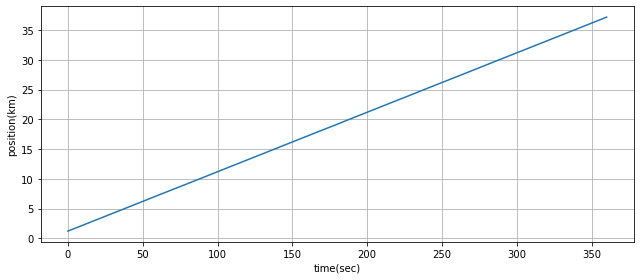

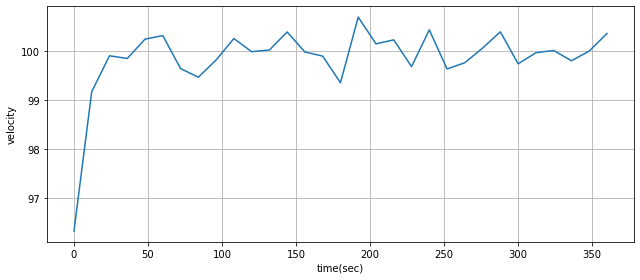

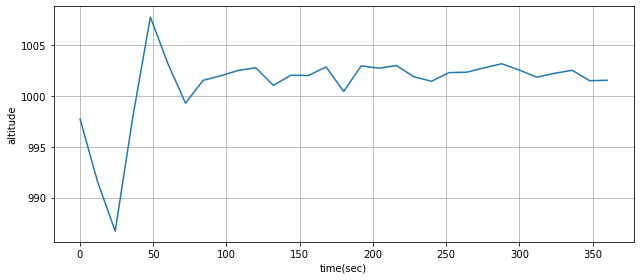

In [93]:
dt = 12. # 12 seconds between readings
range_std = 5 # meters
bearing_std = math.radians(0.5)

ac_pos = (0., 1000.)
ac_vel = (100., 0.)
radar_pos = (0., 0.)
h_radar.radar_pos = radar_pos

points = MerweScaledSigmaPoints(n=3, alpha=.1, beta=2., kappa=0.)
kf = UKF(3, 2, dt, fx=f_radar, hx=h_radar, points=points)

kf.Q[0:2 ,0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
kf.Q[2, 2] = 0.1

kf.R = np.diag([range_std**2, bearing_std**2])
kf.x = np.array([0., 90., 1100.])
kf.P = np.diag([300**2, 30**2, 150**2])

radar = RadarStation((0, 0), range_std, bearing_std)
ac = ACSim(ac_pos, (100, 0), 0.02)

np.random.seed(200)

t = np.arange(0, 360 + dt, dt)
n = len(t)

zs = []
for i in range(len(t)):
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    zs.append([r[0], r[1]])

xs, covs = kf.batch_filter(zs)
ukf_internal.plot_radar(xs, t)

## 平滑结果

Assume that we are tracking a car. Suppose we get a noisy measurement that implies that the car is starting to turn to the left, but the state function has predicted that the car is moving straight. The Kalman filter has no choice but to move the state estimate somewhat towards the noisy measurement, as it cannot judge whether this is just a particularly noisy measurement or the true start of a turn. 
>假设我们在追踪一辆车。假设我们得到一个噪声测量，表明汽车开始左转，但状态函数预测汽车是直线移动。卡尔曼滤波器别无选择，只能将状态估计稍微移向噪声测量，因为它无法判断这是一个特别的噪声测量还是一个真正的转向开始。

If we are collecting data and post-processing it we have measurements after the questionable one that informs us if a turn was made or not. Suppose the subsequent measurements all continue turning left. We can then be sure that the measurement was not very noisy, but instead a turn was initiated.
>如果我们在收集数据并进行后期处理，我们就会在有问题的数据之后进行测量，从而得知是否有转弯。假设随后的测量都继续左转。我们可以确定测量不是很吵，而是开始了一个转弯。

We will not develop the math or algorithm here, I will just show you how to call the algorithm in `FilterPy`. The algorithm that we have implemented is called an *RTS smoother*, after the three inventors of the algorithm: Rauch, Tung, and Striebel.
>我们不会在这里开发数学或算法，我只会告诉你如何调用' FilterPy '中的算法。我们实现的算法被称为*RTS平滑算法*，以算法的三位发明者Rauch, Tung和Striebel命名。

The routine is `UnscentedKalmanFilter.rts_smoother()`. Using it is trivial; we pass in the means and covariances computed from the `batch_filter` step, and receive back the smoothed means, covariances, and Kalman gain.
>例程是`UnscentedKalmanFilter.rts_smoother()`。使用它是微不足道的;我们通过`batch_filter` 步骤计算的平均值和协方差，并接收到平滑的平均值、协方差和卡尔曼增益。

Difference in position in meters:
	 [-1.4166 -0.2815  1.2679 -1.2405 -2.1863]


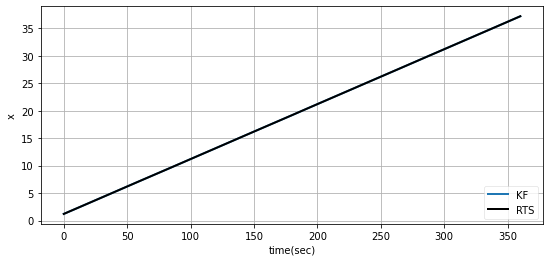

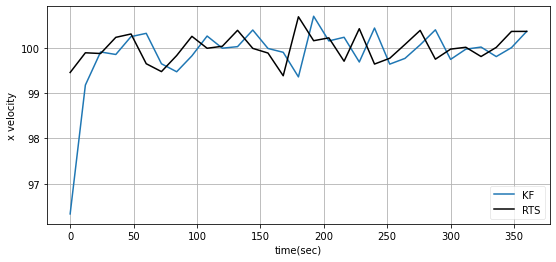

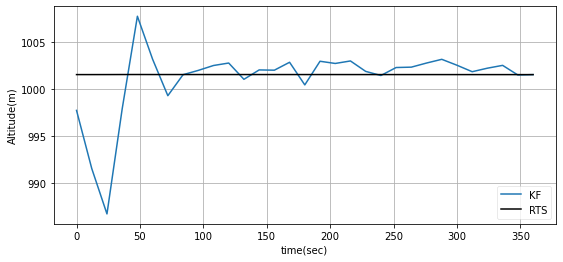

In [94]:
Ms, P, K = kf.rts_smoother(xs, covs)
ukf_internal.plot_rts_output(xs, Ms, t)

From these charts we can see that the improvement in the position is small, but the improvement in the velocity is good, and spectacular for the altitude. The difference in the position are very small, so I printed the difference between the UKF and the smoothed results for the last 5 points. I recommend always using the RTS smoother if you can post-process your data.
>从这些图表中我们可以看出，位置上的改善很小，但速度上的改善很好，高度上的改善也很壮观。位置上的差异非常小，所以我打印了UKF和平滑结果之间的差异为最后5点。如果你能够后期处理你的数据，我建议你更顺畅地使用RTS。

##  选择Sigma参数

I have found the literature on choosing values for $\alpha$, $\beta$, and $\kappa$ to be rather lacking. Van der Merwe's dissertation contains the most information, but it is not exhaustive. So let's explore what they do. 
>我发现关于为$\alpha$， $\beta$和$\kappa$选择值的文献相当缺乏。Van der Merwe的论文包含了大部分信息，但并不详尽。让我们来看看它们是怎么做的。

Van der Merwe suggests using $\beta=2$ for Gaussian problems, and $\kappa=3-n$. So let's start there and vary $\alpha$. I will let $n=1$ to minimize the size of the arrays we need to look at and to avoid having to compute the square root of matrices.
>Van der Merwe建议使用$\beta=2$来解决高斯问题，$\kappa=3-n$。我们从这里开始，改变$\alpha$。我让$n=1$，以最小化我们需要查看的数组的大小，并避免计算矩阵的平方根。

In [95]:
from kf_book.ukf_internal import print_sigmas
print_sigmas(mean=0, cov=3, alpha=1)

sigmas:  [ 0.  3. -3.]
mean weights: [0.6667 0.1667 0.1667]
cov weights: [2.6667 0.1667 0.1667]
lambda: 2
sum cov 2.9999999999999996


So what is going on here? We can see that for a mean of 0 the algorithm chooses sigma points of 0, 3, and -3, but why? Recall the equation for computing the sigma points:
>那么这里发生了什么?我们可以看到，当均值为0时，算法会选择点(0,3，-3)但为什么呢?回想一下计算sigma点的公式:

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\lambda)\Sigma}
\end{aligned}$$

My choice of $n=1$ reduces everything to scalars, allowing us to avoid computing the square root of matrices. So, for our values the equation is
>我选择$n=1$将所有东西都简化成标量，这样我们就不用计算矩阵的平方根了。对于我们的值，方程是

$$\begin{aligned}
\mathcal{X}_0 &= 0 \\
\mathcal{X}_i &= 0 \pm \sqrt{(1+2)\times 3} \\
&= \pm 3
\end{aligned}$$

So as $\alpha$ gets larger the sigma points get more spread out. Let's set it to an absurd value.
>所以，当$\ $变大时，点会更分散。我们把它设为一个荒谬的值。

In [96]:
print_sigmas(mean=0, cov=3, alpha=200)

sigmas:  [   0.  600. -600.]
mean weights: [1. 0. 0.]
cov weights: [-39996.      0.      0.]
lambda: 119999
sum cov -39996.00000000001


We can see that the sigma points spread over 100 standard deviations. If our data was Gaussian we'd be incorporating data many standard deviations away from the mean; for nonlinear problems this is unlikely to produce good results. But suppose our distribution was not Gaussian, but instead had very fat tails? We might need to sample from those tails to get a good estimate, and hence it would make sense to make $\kappa$ larger (not 200, which was absurdly large to make the change in the sigma points stark). 
>我们可以看到标准差分布在100个标准差上。如果我们的数据是高斯分布的我们就会合并离均值很多标准差的数据;对于非线性问题，这不大可能产生好的结果。但假设我们的分布不是高斯分布，而是非常大的尾部?我们可能需要从这些尾部取样，以得到一个好的估计，因此它将有意义使$\kappa$更大(不是200，这是荒谬的大，使sigma点的变化明显)。

With a similar line of reasoning, suppose that our distribution has nearly no tails - the probability distribution looks more like an inverted parabola. In such a case we'd probably want to pull the sigma points in closer to the mean to avoid sampling in regions where there will never be real data.
>用类似的推理思路，假设我们的分布几乎没有尾部——概率分布看起来更像一个倒抛物线。在这种情况下，我们可能想把∑点拉得更接近均值，以避免在永远不会有真实数据的区域进行抽样。

Now let's look at the change in the weights. When we have $k+n=3$ the weights were 0.6667 for the mean, and 0.1667 for the two outlying sigma points. On the other hand, when $\alpha=200$ the mean weight shot up to 0.99999 and the outlier weights were set to 0.000004. Recall the equations for the weights:
>现在我们来看看权重的变化。当我们有$k+n=3$时，均值的权重是0.6667，两个离群点的权重是0.1667。另一方面，当$\alpha=200$时，平均权重上升到0.99999，离群权重设置为0.000004。回想一下权重的公式:

$$\begin{aligned}
W_0 &= \frac{\lambda}{n+\lambda} \\
W_i &= \frac{1}{2(n+\lambda)}
\end{aligned}$$

We can see that as $\lambda$ gets larger the fraction for the weight of the mean ($\lambda/(n+\lambda)$) approaches 1, and the fraction for the weights of the rest of the sigma points approaches 0. This is invariant on the size of your covariance. So as we sample further and further away from the mean we end up giving less weight to those samples, and if we sampled very close to the mean we'd give very similar weights to all.
>我们可以看到，当$\ $变大时，均值的权重($\lambda/(n+\lambda)$)趋近于1，其余点的权重的比例趋近于0。这对协方差大小是不变的。样本离均值越远，权重越小样本离均值越近，权重越小样本离均值越近，权重越小。

However, the advice that Van der Merwe gives is to constrain $\alpha$ in the range $0 \gt \alpha \ge 1$. He suggests $10^{-3}$ as a good value. Let's try that.
>然而，Van der Merwe给出的建议是将$\alpha$限制在$0 \gt \alpha \ge 1$的范围内。他认为10^{-3}美元是个不错的价格。让我们试试。

In [97]:
print_sigmas(mean=0, cov=13, alpha=.001, kappa=0)

sigmas:  [ 0.      0.0036 -0.0036]
mean weights: [-999999.  500000.  500000.]
cov weights: [-999996.  500000.  500000.]
lambda: -0.999999
sum cov 3.9999989999923855


## 机器人定位-一个完全工作的例子

It is time to undertake a significant problem. Most books choose simple, textbook problems with simple answers, and you are left wondering how to implement a real world problem. This example will not teach you how to tackle any problem, but illustrates the type of things you will have to consider as you design and implement a filter. 
>现在是着手解决一个重大问题的时候了。大多数书都选择简单的、课本上的问题和简单的答案，而你却不知道如何实现现实世界中的问题。这个示例不会教你如何处理任何问题，但说明了在设计和实现过滤器时必须考虑的事情类型。

We will consider the problem of robot localization. In this scenario we have a robot that is moving through a landscape using a sensor to detect landmarks. This could be a self driving car using computer vision to identify trees, buildings, and other landmarks. It might be one of those small robots that vacuum your house, or a robot in a warehouse.
>我们将考虑机器人的定位问题。在这个场景中，我们有一个机器人，它正在通过一个传感器来检测地标。这可能是一辆使用计算机视觉识别树木、建筑和其他地标的自动驾驶汽车。它可能是那些为你的房子吸尘的小型机器人，或者是仓库里的机器人。

The robot has 4 wheels in the same configuration used by automobiles. It maneuvers by pivoting the front wheels. This causes the robot to pivot around the rear axle while moving forward. This is nonlinear behavior which we will have to model. 
>机器人有4个轮子，配置与汽车相同。它通过转动前轮来操纵。这使得机器人在前进时绕后轴旋转。这是我们需要建模的非线性行为。

The robot has a sensor that gives it approximate range and bearing to known targets in the landscape. This is nonlinear because computing a position from  a range and bearing requires square roots and trigonometry. 
>机器人有一个传感器，可以给出它与已知目标的大致距离和方位。这是非线性的，因为从一个范围和方位计算一个位置需要平方根和三角。

Both the process model and measurement models are nonlinear. The UKF accommodates both, so we provisionally conclude that the UKF is a viable choice for this problem.
>过程模型和度量模型都是非线性的。UKF兼顾了这两种情况，所以我们暂时认为UKF是解决这个问题的可行选择。

### 机器人运动模型

At a first approximation an automobile steers by pivoting the front tires while moving forward. The front of the car moves in the direction that the wheels are pointing while pivoting around the rear tires. This simple description is complicated by issues such as slippage due to friction, the differing behavior of the rubber tires at different speeds, and the need for the outside tire to travel a different radius than the inner tire. Accurately modeling steering requires a complicated set of differential equations. 
>近似地说，汽车是通过向前移动时转动前轮来控制方向的。汽车的前部在以后轮为中心转动时，会朝着车轮指向的方向移动。这种简单的描述由于摩擦引起的滑移、橡胶轮胎在不同速度下的不同行为，以及外胎行驶半径与内胎不同的需求等问题而变得复杂。精确的转向建模需要一套复杂的微分方程。

For Kalman filtering, especially for lower speed robotic applications a simpler *bicycle model* has been found to perform well. This is a depiction of the model:
>对于卡尔曼滤波，特别是低速机器人应用，一个简单的*自行车模型*已经被发现表现良好。这是模型的描述:

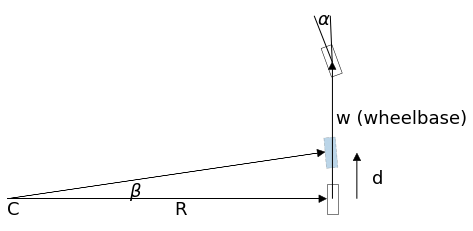

In [98]:
ekf_internal.plot_bicycle()

Here we see the front tire is pointing in direction $\alpha$ relative to the wheelbase. Over a short time period the car moves forward and the rear wheel ends up further ahead and slightly turned inward, as depicted with the blue shaded tire. Over such a short time frame we can approximate this as a turn around a radius $R$. We can compute the turn angle $\beta$ with
>在这里，我们看到前轮胎指向方向$\alpha$相对于轴距。在很短的一段时间内，汽车向前移动，后轮最终进一步向前，并轻微转向内，如图所示的蓝色阴影轮胎。在如此短的时间内，我们可以将其近似为一个半径为R$的转弯。我们可以计算转弯角度$\ $

$$\beta = \frac{d}{w} \tan{(\alpha)}$$

and the turning radius R is given by 
>转弯半径R为

$$R = \frac{d}{\beta}$$

where the distance the rear wheel travels given a forward velocity $v$ is $d=v\Delta t$.
>在给定前进速度$v$的情况下，后轮行驶的距离是$d=v\ t$。

With $\theta$ being the robot's orientation we compute the position $C$ before the turn starts as
>以$\theta$为机器人的方向，我们在开始转弯前计算位置$C$为

$$\begin{aligned}
C_x &= x - R\sin(\theta) \\
C_y &= y + R\cos(\theta)
\end{aligned}$$

After the move forward for time $\Delta t$ the new position and orientation of the robot is
>向前移动时间$\Delta t$后，机器人的新位置和方向为

$$\begin{aligned} \bar x &= C_x + R\sin(\theta + \beta) \\
\bar y &= C_y - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

Once we substitute in for $C$ we get
>一旦我们把$C$代入

$$\begin{aligned} \bar x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
\bar y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\bar \theta &= \theta + \beta
\end{aligned}
$$

You do not need to understand this math in detail if you are not interested in steering models. The important thing to recognize is that our motion model is nonlinear, and we will need to deal with that with our Kalman filter.
>如果你对转向模型不感兴趣，你不需要了解这个数学细节。重要的是要认识到我们的运动模型是非线性的，我们需要用卡尔曼滤波器来处理它。

### 设计状态变量

For our robot we will maintain the position and orientation:
>对于我们的机器人，我们将保持以下位置和方向:

$$\mathbf x = \begin{bmatrix}x & y & \theta\end{bmatrix}^\mathsf{T}$$

I could include velocities into this model, but as you will see the math will already be quite challenging.
>我可以将速度包含到这个模型中，但正如你将看到的那样，数学已经相当具有挑战性。

The control input $\mathbf{u}$ is the commanded velocity and steering angle
>控制输入$\mathbf{u}$为指令速度和转向角度

$$\mathbf{u} = \begin{bmatrix}v & \alpha\end{bmatrix}^\mathsf{T}$$

### 设计系统模型

We model our system as a nonlinear motion model plus white noise.
>我们将系统建模为非线性运动模型加上白噪声。

$$\bar x = x + f(x, u) + \mathcal{N}(0, Q)$$

Using the motion model for a robot that we created above, we can write:
>使用我们上面创建的机器人的运动模型，我们可以这样写:

In [99]:
from math import tan, sin, cos, sqrt

def move(x, dt, u, wheelbase):
    hdg = x[2]
    vel = u[0]
    steering_angle = u[1]
    dist = vel * dt

    if abs(steering_angle) > 0.001: # is robot turning?
        beta = (dist / wheelbase) * tan(steering_angle)
        r = wheelbase / tan(steering_angle) # radius

        sinh, sinhb = sin(hdg), sin(hdg + beta)
        cosh, coshb = cos(hdg), cos(hdg + beta)
        return x + np.array([-r*sinh + r*sinhb, 
                              r*cosh - r*coshb, beta])
    else: # moving in straight line
        return x + np.array([dist*cos(hdg), dist*sin(hdg), 0])

We will use this function to implement the state transition function `f(x)`.
>我们将使用这个函数来实现状态转移函数' f(x) '。

I will design the UKF so that $\Delta t$ is small. If the robot is moving slowly then this function should give a reasonably accurate prediction. If $\Delta t$ is large or your system's dynamics are very nonlinear this method will fail.  In those cases you will need to implement it using a more sophisticated numerical integration technique such as Runge Kutta. Numerical integration is covered briefly in the **Kalman Filter Math** chapter.
>我将设计UKF使$\Delta t$是小的。如果机器人移动缓慢，那么这个函数应该给出合理准确的预测。如果$\Delta t$很大或者你的系统动力学是非常非线性的，这个方法将会失败。在这些情况下，您需要使用更复杂的数值积分技术(如龙格库塔)来实现它。数值积分在**卡尔曼滤波数学**一章中有简要介绍。

### 设计测量模型

The sensor provides a noisy bearing and range to multiple known locations in the landscape. The measurement model must convert the state $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf{T}$ into a range and bearing to the landmark. If $p$ is the position of a landmark, the range $r$ is
>该传感器提供了一个有噪声的方位和多个已知位置的范围。测量模型必须将状态$\begin{bmatrix}x & y& theta\end{bmatrix}^\mathsf{T}$转换为地标的范围和方位。如果$p$是一个地标的位置，则$r$的范围是

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

We assume that the sensor provides bearing relative to the orientation of the robot, so we must subtract the robot's orientation from the bearing to get the sensor reading, like so:
>我们假设传感器提供了相对于机器人方向的轴承，因此我们必须从轴承中减去机器人的方向来获得传感器读数，如下所示:

$$\phi = \tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$$

Thus our measurement function is
>因此我们的测量函数是

$$\begin{aligned}
\mathbf{z}& = h(\mathbf x, \mathbf P) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

I will not implement this yet as there is a difficulty that will be discussed in the *Implementation* section below.
>我不会实现它，因为有一个困难，将在下面的*实现部分讨论。

### 设计测量噪声

It is reasonable to assume that the range and bearing measurement noise is independent, hence
>可以合理地假设距离和轴承测量噪声是独立的，因此

$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### 实现

Before we begin coding we have another issue to handle. The residual is $y = z - h(x)$. Suppose z has a bearing of $1^\circ$ and $h(x)$ is $359^\circ$. Subtracting them gives $-358^\circ$. This will throw off the computation of the Kalman gain because the correct angular difference is $2^\circ$. So we will have to write code to correctly compute the bearing residual.
>在我们开始编码之前，我们有另一个问题要处理。剩余是$y = z - h(x)$。假设z的方位为$1^\circ$， $h(x)$为$359^ circ$。减去它们得到$-358^\circ$。这将摆脱卡尔曼增益的计算，因为正确的角差是$2^\circ$。所以我们必须编写代码来正确计算距离残差。

In [100]:
def normalize_angle(x):
    x = x % (2 * np.pi)    # force in range [0, 2 pi)
    if x > np.pi:          # move to [-pi, pi)
        x -= 2 * np.pi
    return x

In [101]:
print(np.degrees(normalize_angle(np.radians(1-359))))

1.9999999999999774


The state vector has the bearing at index 2, but the measurement vector has it at index 1, so we need to write functions to handle each. Another issue we face is that as the robot maneuvers different landmarks will be visible, so we need to handle a variable number of measurements. The function for the residual in the measurement will be passed an array of several measurements, one per landmark.
>状态向量在索引2处有方位，但测量向量在索引1处有方位，因此我们需要编写函数来处理每个方位。我们面临的另一个问题是，随着机器人的机动，不同的地标将是可见的，所以我们需要处理不同数量的测量。测量中的残差函数将传递多个测量值的数组，每个地标一个。

In [102]:
def residual_h(a, b):
    y = a - b
    # data in format [dist_1, bearing_1, dist_2, bearing_2,...]
    for i in range(0, len(y), 2):
        y[i + 1] = normalize_angle(y[i + 1])
    return y

def residual_x(a, b):
    y = a - b
    y[2] = normalize_angle(y[2])
    return y

We can now implement the measurement model. The equation is
>我们现在可以实现度量模型。方程是
$$h(\mathbf x, \mathbf P)
= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix}$$

The expression $\tan^{-1}(\frac{p_y - y}{p_x - x}) - \theta$ can produce a result outside the range $[-\pi, \pi)$, so we should normalize the angle to that range.
>表达式$\tan^{-1}(\frac{p_y - y}{p_x - x}) - theta$会产生一个超出$[-\pi， \pi)$范围的结果，所以我们应该将角度归一化到这个范围。

The function will be passed an array of landmarks and needs to produce an array of measurements in the form 
`[dist_to_1, bearing_to_1, dist_to_2, bearing_to_2, ...]`.
>该函数将传递一个数组的地标和需要产生一个数组的测量形式
(dist_to_1、bearing_to_1 dist_to_2、bearing_to_2…]”。

In [103]:
def Hx(x, landmarks):
    """ takes a state variable and returns the measurement
    that would correspond to that state. """
    hx = []
    for lmark in landmarks:
        px, py = lmark
        dist = sqrt((px - x[0])**2 + (py - x[1])**2)
        angle = atan2(py - x[1], px - x[0])
        hx.extend([dist, normalize_angle(angle - x[2])])
    return np.array(hx)

Our difficulties are not over. The unscented transform computes the average of the state and measurement vectors, but each contains a bearing. There is no unique way to compute the average of a set of angles. For example, what is the average of 359$^\circ$ and 3$^\circ$? Intuition suggests the answer should be 1$^\circ$, but a naive $\frac{1}{n}\sum x$ approach yields 181$^\circ$.
>我们的困难还没有结束。无气味变换计算状态向量和测量向量的平均值，但每个向量都包含一个方位。没有唯一的方法来计算一组角的平均值。例如，359$^\circ$和3$^\circ$的平均值是多少?直觉告诉我们答案应该是1$^\circ$，但是简单的$\frac{1}{n} sum x$方法会得到181$^\circ$。

One common approach is to take the arctan of the sum of the sins and cosines.
>一种常见的方法是求sin和cos之和的arctan。

$$\bar{\theta} = atan2\left(\frac{\sum_{i=1}^n \sin\theta_i}{n}, \frac{\sum_{i=1}^n \cos\theta_i}{n}\right)$$

`UnscentedKalmanFilter.__init__()` has an argument `x_mean_fn` for a function which computes the mean of the state, and `z_mean_fn` for a function which computes the mean of the measurement. We will code these function as:
>' UnscentedKalmanFilter.__init__() '有一个参数' x_mean_fn '用于计算状态的平均值，' z_mean_fn '用于计算测量值的平均值。我们将这些函数编码为:

In [104]:
def state_mean(sigmas, Wm):
    x = np.zeros(3)

    sum_sin = np.sum(np.dot(np.sin(sigmas[:, 2]), Wm))
    sum_cos = np.sum(np.dot(np.cos(sigmas[:, 2]), Wm))
    x[0] = np.sum(np.dot(sigmas[:, 0], Wm))
    x[1] = np.sum(np.dot(sigmas[:, 1], Wm))
    x[2] = atan2(sum_sin, sum_cos)
    return x

def z_mean(sigmas, Wm):
    z_count = sigmas.shape[1]
    x = np.zeros(z_count)

    for z in range(0, z_count, 2):
        sum_sin = np.sum(np.dot(np.sin(sigmas[:, z+1]), Wm))
        sum_cos = np.sum(np.dot(np.cos(sigmas[:, z+1]), Wm))

        x[z] = np.sum(np.dot(sigmas[:,z], Wm))
        x[z+1] = atan2(sum_sin, sum_cos)
    return x

These functions take advantage of the fact that NumPy's trigometric functions operate on arrays, and `dot` performs element-wise multiplication. NumPy is implemented in C and Fortran, so `sum(dot(sin(x), w))` is much faster than writing the equivalent loop in Python.
>这些函数利用了NumPy的三角函数对数组进行操作，而“点”执行元素的乘法。NumPy是用C和Fortran实现的，所以' sum(dot(sin(x)， w)) '比在Python中编写等价循环要快得多。

With that done we are now ready to implement the UKF. I want to point out that when I designed this filter I did not just design all of functions above in one sitting, from scratch. I put together a basic UKF with predefined landmarks, verified it worked, then started filling in the pieces. "What if I see different landmarks?" That lead me to change the measurement function to accept an array of landmarks. "How do I deal with computing the residual of angles?" This led me to write the angle normalization code. "What is the *mean* of a set of angles?" I searched on the internet, found an article on Wikipedia, and implemented that algorithm. Do not be daunted. Design what you can, then ask questions and solve them, one by one.
>完成这些之后，我们现在就可以实现UKF了。我想指出的是，当我设计这个过滤器时，我并没有一次从头开始设计所有的功能。我把一个基本的UKF和预定义的地标放在一起，验证它的工作，然后开始填充碎片。“如果我看到不同的地标怎么办?”这导致我改变了测量功能，以接受一组地标。"我怎么计算余角呢"这促使我编写了角度规范化代码。“一组角的*均值*是什么”我在网上搜索，在维基百科上找到了一篇文章，然后实现了那个算法。不要气馁。设计你能设计的，然后问问题，一个接一个地解决它们。

You've seen the UKF implemention already, so I will not describe it in detail. There are two new thing here. When we construct the sigma points and filter we have to provide it the functions that we have written to compute the residuals and means.
>您已经看到了UKF实现，所以我不会详细描述它。这里有两个新东西。当我们构造点和过滤器时我们必须给它提供我们写过的用来计算残差和均值的函数。

```python
points = SigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                     subtract=residual_x)

ukf = UKF(dim_x=3, dim_z=2, fx=fx, hx=Hx, dt=dt, points=points,
         x_mean_fn=state_mean, z_mean_fn=z_mean,
         residual_x=residual_x, residual_z=residual_h)
```

Next, we need to pass extra data into our `f(x, dt)` and `h(x)` functions. We want to use `move(x, dt, u, wheelbase)` for `f(x, dt)`, and `Hx(x, landmarks)` for `h(x)`. We can do this, we just have to pass the extra parameters into `predict()` and `update()` as keyword argument,s like so:
>接下来，我们需要向' f(x, dt) '和' h(x) '函数传递额外的数据。我们想用' move(x, dt, u，轴距)'来表示' f(x, dt) '，用' Hx(x, landmark) '来表示' h(x) '。我们可以这样做，我们只需要将额外的参数传递给' predict() '和' update() '作为关键字参数，就像这样:

```python
            ukf.predict(u=u, wheelbase=wheelbase)        
            ukf.update(z, landmarks=landmarks)
```

The rest of the code runs the simulation and plots the results. I create a variable `landmarks` that contains the coordinates of the landmarks. I update the simulated robot position 10 times a second, but run the UKF only once per second.  We are not using Runge Kutta to integrate the differential equations of motion, so a small time step makes the simulation more accurate.
>其余代码运行模拟并绘制结果。我创建了一个变量“landmarks”，它包含了landmarks的坐标。我每秒更新模拟机器人的位置10次，但每秒只运行UKF一次。我们没有使用龙格库塔来积分运动微分方程，所以

In [105]:
from filterpy.stats import plot_covariance_ellipse

dt = 1.0
wheelbase = 0.5

def run_localization(
    cmds, landmarks, sigma_vel, sigma_steer, sigma_range, 
    sigma_bearing, ellipse_step=1, step=10):

    plt.figure()
    points = MerweScaledSigmaPoints(n=3, alpha=.00001, beta=2, kappa=0, 
                                    subtract=residual_x)
    ukf = UKF(dim_x=3, dim_z=2*len(landmarks), fx=move, hx=Hx,
              dt=dt, points=points, x_mean_fn=state_mean, 
              z_mean_fn=z_mean, residual_x=residual_x, 
              residual_z=residual_h)

    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .05])
    ukf.R = np.diag([sigma_range**2, 
                     sigma_bearing**2]*len(landmarks))
    ukf.Q = np.eye(3)*0.0001
    
    sim_pos = ukf.x.copy()
    
    # plot landmarks
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], 
                    marker='s', s=60)
    
    track = []
    for i, u in enumerate(cmds):     
        sim_pos = move(sim_pos, dt/step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='k', alpha=0.3)

            x, y = sim_pos[0], sim_pos[1]
            z = []
            for lmark in landmarks:
                dx, dy = lmark[0] - x, lmark[1] - y
                d = sqrt(dx**2 + dy**2) + randn()*sigma_range
                bearing = atan2(lmark[1] - y, lmark[0] - x)
                a = (normalize_angle(bearing - sim_pos[2] + 
                     randn()*sigma_bearing))
                z.extend([d, a])            
            ukf.update(z, landmarks=landmarks)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ukf.x[0], ukf.x[1]), ukf.P[0:2, 0:2], std=6,
                     facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF Robot localization")
    plt.show()
    return ukf

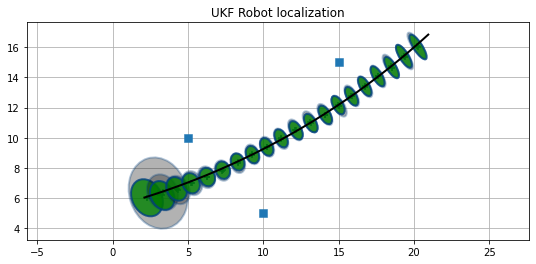

Final P: [0.0092 0.0187 0.0007]


In [106]:
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1)
print('Final P:', ukf.P.diagonal())

The rest of the code runs the simulation and plots the results. I create a variable `landmarks` that contains the coordinates of the landmarks. I update the simulated robot position 10 times a second, but run the UKF only once. This is for two reasons. First, we are not using Runge Kutta to integrate the differental equations of motion, so a narrow time step allows our simulation to be more accurate. Second, it is fairly normal in embedded systems to have limited processing speed. This forces you to run your Kalman filter only as frequently as absolutely needed.
>其余代码运行模拟并绘制结果。我创建了一个变量“landmarks”，它包含了landmarks的坐标。我每秒更新模拟机器人位置10次，但只运行UKF一次。这有两个原因。首先，我们没有使用龙格-库塔来整合运动微分方程，所以较窄的时间步长可以让我们的模拟更精确。其次，在嵌入式系统中，有限的处理速度是相当正常的。这迫使您只在绝对需要的时候频繁地运行卡尔曼滤波器。

### 转向机器人

The steering simulation in the run above is not realistic. The velocity and steering angles never changed, which doesn't pose much of a problem for the Kalman filter. We could implement a complicated PID controlled robot simulation, but I will just generate varying steering commands using NumPy's `linspace` method. I'll also add more landmarks as the robot will be traveling much further than in the first example.
>在上面运行的转向模拟是不现实的。速度和转向角度从未改变，这对卡尔曼滤波器来说并没有太大的问题。我们可以实现一个复杂的PID控制机器人仿真，但我将使用NumPy的“linspace”方法生成不同的转向命令。我还将添加更多的地标，因为机器人将比第一个例子中走得更远。

In [107]:
landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5],
                      [0, 30], [50, 30], [40, 10]])
dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

def turn(v, t0, t1, steps):
  return [[v, a] for a in np.linspace(
                 np.radians(t0), np.radians(t1), steps)]  
    
# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend(turn(v, 0, 2, 15))
cmds.extend([cmds[-1]]*100)

#turn right
cmds.extend(turn(v, 2, -2, 15))
cmds.extend([cmds[-1]]*200)

cmds.extend(turn(v, -2, 0, 15))
cmds.extend([cmds[-1]]*150)

cmds.extend(turn(v, 0, 1, 25))
cmds.extend([cmds[-1]]*100)

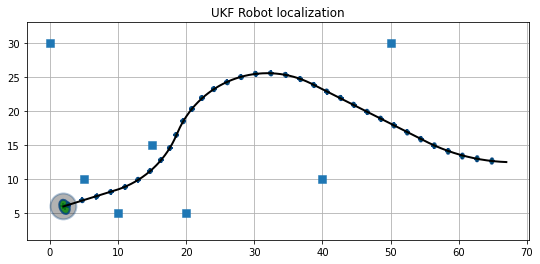

final covariance [0.0013 0.0043 0.0004]


In [108]:
ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

The uncertainty becomes very small very quickly. The covariance ellipses are displaying the $6\sigma$ covariance, yet the ellipses are so small they are hard to see. We can incorporate more error into the answer by only supplying two landmarks near the start point. When we run this filter the errors increase as the robot gets further away from these landmarks.
>不确定性很快变得很小。协方差椭圆显示$6\sigma$协方差，但椭圆太小，很难看到。只要在起点附近提供两个里程碑，我们就可以在答案中加入更多的错误。当我们运行这个过滤器时，误差会随着机器人离这些地标的距离越来越远而增加。

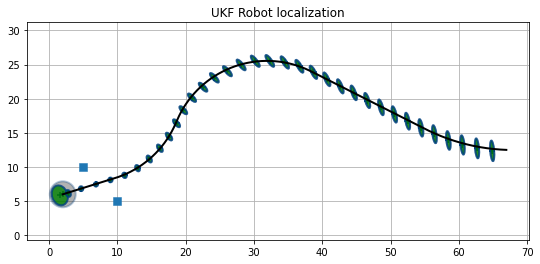

final covariance [0.0026 0.0657 0.0008]


In [109]:
ukf = run_localization(
    cmds, landmarks[0:2], sigma_vel=0.1, sigma_steer=np.radians(1),
    sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

## 讨论

Your impression of this chapter probably depends on how many nonlinear Kalman filters you have implemented in the past. If this is your first exposure perhaps the computation of $2n+1$ sigma points and the subsequent writing of the $f(x)$ and $h(x)$ function struck you as a bit finicky. Indeed, I spent more time than I'd care to admit getting everything working because of the need to handle the modular math of angles. On the other hand, if you have implemented an extended Kalman filter (EKF) perhaps you are bouncing gleefully in your seat. There is a small amount of tedium in writing the functions for the UKF, but the concepts are very basic. The EKF for the same problem requires some fairly difficult mathematics. For many problems we cannot find a closed form solution for the equations of the EKF, and we must retreat to some sort of iterated solution.
>你对这一章的印象可能取决于你在过去实现过多少非线性卡尔曼滤波器。如果这是你的第一次接触，也许$2n+1$ sigma点的计算和随后的$f(x)$和$h(x)$函数的书写让你感到有点挑剔。事实上，我花了比我愿意承认的更多的时间来让一切运转起来，因为需要处理角度的模块化数学。另一方面，如果你已经实现了扩展卡尔曼滤波器(EKF)，也许你会在你的座位上高兴地跳跃。在为UKF编写函数的过程中，有一点乏味，但是概念是非常基本的。同样的问题的EKF需要一些相当困难的数学。对于许多问题，我们不能找到一个封闭形式的解的EKF方程，我们必须撤退到某种迭代解。

The advantage of the UKF over the EKF is not only the relative ease of implementation. It is somewhat premature to discuss this because you haven't learned the EKF yet, but the EKF linearizes the problem at one point and passes that point through a linear Kalman filter. In contrast, the UKF takes $2n+1$ samples. Therefore the UKF is often more accurate than the EKF, especially when the problem is highly nonlinear. While it is not true that the UKF is guaranteed to always outperform the EKF, in practice it has been shown to perform at least as well, and usually much better than the EKF. 
>UKF相对于EKF的优势不仅在于相对容易实现。现在讨论这个有点为时过早，因为你们还没有学过EKF，但是EKF将问题在一点线性化并通过线性卡尔曼滤波器。相比之下，UKF采用$2n+1$样本。因此，UKF通常比EKF更准确，特别是当问题是高度非线性的时候。虽然并不是说UKF总能胜过EKF，但在实践中，它的表现至少和EKF一样好，而且通常比EKF好得多。

Hence my recommendation is to always start by implementing the UKF. If your filter has real world consequences if it diverges (people die, lots of money lost, power plant blows up) of course you will have to engage in sophisticated analysis and experimentation to choose the best filter. That is beyond the scope of this book, and you should be going to graduate school to learn this theory. 
>因此，我的建议是始终从实施UKF开始。如果你的过滤器有现实世界的后果，如果它偏离了(人们死亡，大量的金钱损失，发电厂爆炸)，当然你将不得不从事复杂的分析和实验，以选择最好的过滤器。这超出了这本书的范围，你应该去研究生院学习这个理论。

Finally, I have spoken of the UKF as *the* way to perform sigma point filters. This is not true. The specific version I chose is Julier's scaled unscented filter as parameterized by Van der Merwe in his 2004 dissertation. If you search for Julier, Van der Merwe, Uhlmann, and Wan you will find a family of similar sigma point filters that they developed. Each technique uses a different way of choosing and weighting the sigma points. But the choices don't stop there. For example, the SVD Kalman filter uses singular value decomposition (SVD) to find the approximate mean and covariance of the probability distribution. Think of this chapter as an introduction to the sigma point filters, rather than a definitive treatment of how they work.
>最后，我提到了UKF作为执行sigma点过滤器的方式。这不是真的。我选择的具体版本是由Van der Merwe在2004年的论文中参数化的Julier的缩放无气味过滤器。如果你搜索Julier, Van der Merwe, Uhlmann和Wan，你会发现他们开发的一组相似的sigma点滤波器。每种技术都使用不同的方法来选择和加权点。但选择并不止于此。例如，SVD卡尔曼滤波器使用奇异值分解(SVD)来寻找概率分布的近似均值和协方差。把这一章看作是对sigma点过滤器的介绍，而不是对它们如何工作的明确处理。

## 参考

- [1] Rudolph Van der Merwe. "Sigma-Point Kalman Filters for Probabilistic Inference in Dynamic State-Space Models" dissertation (2004).

- [2] Simon J. Julier. "The Scaled Unscented Transformation". Proceedings of the American Control Conference 6. IEEE. (2002)

- [1] http://www.esdradar.com/brochures/Compact%20Tracking%2037250X.pdf

- [2] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

- [3] Cholesky decomposition. Wikipedia. http://en.wikipedia.org/wiki/Cholesky_decomposition